# Data Engineering and Visualization

In [1]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
csv_files = glob.glob('*.csv')
csv_files

['dowjones.csv',
 'FEDFUNDS.csv',
 'goldprice.csv',
 'oilprice.csv',
 'united-states-inflation-rate-cpi.csv',
 'USDCHF=X.csv',
 'USDCHF=X_true.csv',
 'USDEUR=X.csv',
 'USDEUR=X_true.csv',
 'USDGBP=X.csv',
 'USDGBP=X_true.csv']

In [3]:
#personal preference
filepath=['USDEUR=X.csv','USDGBP=X.csv','USDCHF=X.csv']

In [4]:
df_train=[]
df_test=[]
df_raw=[]
for path in filepath:
    df_temp=pd.read_csv(path)
    #We no longer need date, because we can use index.
    df_temp=df_temp[['Close']]
    df_temp.columns=['rate']
    # Somehow USDCHF=X.csv has one more day 2023/11/4, which shouldn't exist.
    if (path=='USDCHF=X.csv'):
        df_temp.drop(df_temp.index[-1], inplace=True)
    df_raw.append(df_temp)
    df_train.append(df_temp[:-5])
    df_test.append(df_temp[-5:])

In [5]:
for i in range(3):
    print(len(df_raw[i]))

2610
2610
2610


In [6]:
# There is something wrong with the files downloaded from the website.
# These rows shouldn't be nan.
# In this case, we simply adopt a strategy of dropping these rows.
# 2017/7/11 2017/11/16 2019/5/22
for i in range(len(filepath)):
    rows_with_nan = df_train[0][df_train[0].isna().any(axis=1)].index
    print(rows_with_nan)
for i in range(len(filepath)):
    df_train[i]=df_train[i].dropna()



Index([961, 1053, 1447], dtype='int64')
Index([961, 1053, 1447], dtype='int64')
Index([961, 1053, 1447], dtype='int64')


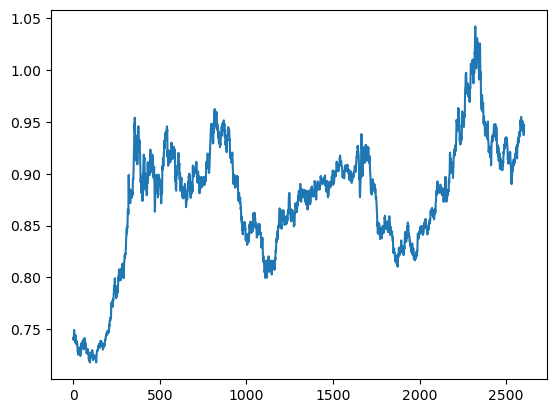

In [7]:
plt.plot(np.array(df_train[0].index),np.array(df_train[0])[:])

In [8]:
def test_stationarity(timeseries):
    # execute Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    print(f'p-value={dftest[1]}')

In [9]:
# First order difference is enough to make timeseries stationary, beacuase p-value<0.05. 
for i in range(len(filepath)):
    print(f"{i}:")
    test_stationarity(df_train[i]['rate'])
    #test first-order difference
    test_stationarity(df_train[i]['rate'].diff().dropna())

0:
p-value=0.21904042654002837
p-value=0.0
1:
p-value=0.3425045203889263
p-value=0.0
2:
p-value=0.04668140961050778
p-value=0.0


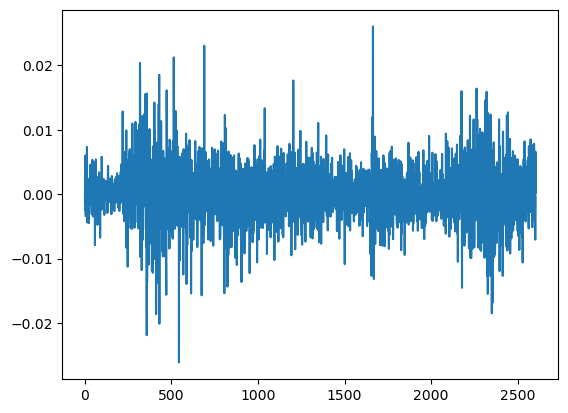

In [10]:
# By utilizing first order difference, we have made the timeseries stationary
plt.plot(df_train[0].diff().dropna())

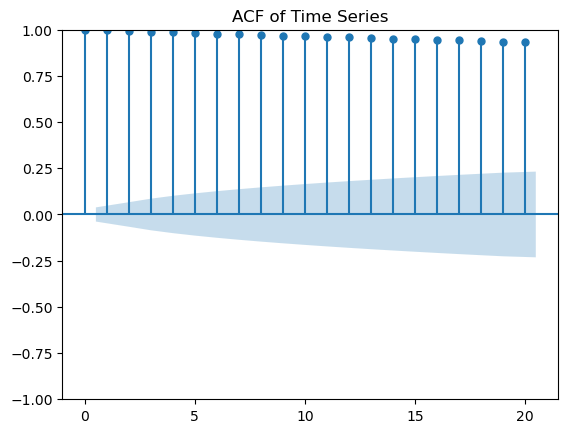

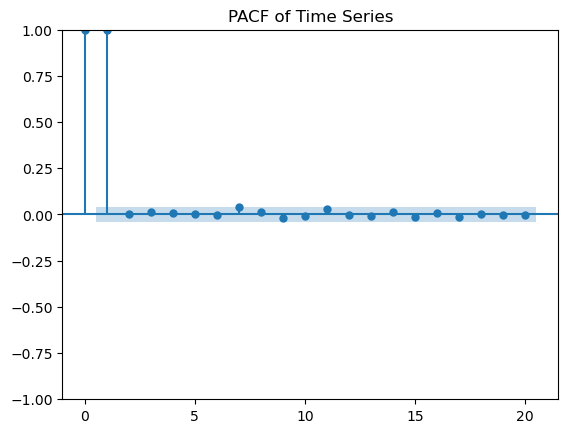

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot ACF figure
plot_acf(df_train[0], lags=20)
plt.title('ACF of Time Series')
plt.show()

# plot PACF figure
plot_pacf(df_train[0], lags=20)
plt.title('PACF of Time Series')
plt.show()

## Read in gold price 

In [12]:
gold_df = pd.read_csv("goldprice.csv")
# Set the 'date' column as the index
gold_df.set_index('date', inplace=True)
# Select rows between 2013-11-04 and 2023-11-03
selected_gold_df = gold_df.loc['2013-11-04':'2023-11-03']
# Apply linear interpolation for NaN values
selected_gold_df_interpolated = selected_gold_df.interpolate(method='linear')
selected_gold_df_interpolated = selected_gold_df_interpolated.reset_index()
selected_gold_df_interpolated["date"]

0       2013-11-04
1       2013-11-05
2       2013-11-06
3       2013-11-07
4       2013-11-08
           ...    
2559    2023-10-30
2560    2023-10-31
2561    2023-11-01
2562    2023-11-02
2563    2023-11-03
Name: date, Length: 2564, dtype: object

In [13]:
# First get the dates from currency 
df_temp=pd.read_csv("USDGBP=X.csv")
df_temp = df_temp.rename(columns={'Date': 'date'})
df_temp['date'] = pd.to_datetime(df_temp['date'])
dates_to_remove = pd.to_datetime(['2017-07-11', '2017-11-16', '2019-05-22'])
df_temp = df_temp[~df_temp['date'].isin(dates_to_remove)]
selected_gold_df_interpolated['date'] = pd.to_datetime(selected_gold_df_interpolated['date'])
merged_df = pd.merge(df_temp, selected_gold_df_interpolated, on='date', how='left')

merged_df['date'] = pd.to_datetime(merged_df['date'])

# Set the 'date' column as the index for interpolation
merged_df.set_index('date', inplace=True)

# Perform linear interpolation on the 'oil_price' column
merged_df[' value'] = merged_df[' value'].interpolate(method='linear')

# Reset the index if needed
merged_df = merged_df.reset_index()

merged_df[" value"]

0       1314.2500
1       1311.2500
2       1317.0000
3       1316.0000
4       1309.0000
          ...    
2602    1996.0976
2603    1984.0109
2604    1984.4608
2605    1984.1135
2606    1992.2804
Name:  value, Length: 2607, dtype: float64

In [14]:
gold_price = merged_df[" value"].values
gold_price.shape # Same length as currency exchange history 

(2607,)

## Read in oil price 

In [15]:
oil_df = pd.read_csv("oilprice.csv")
# Set the 'date' column as the index
oil_df.set_index('date', inplace=True)
# Select rows between 2013-11-04 and 2023-11-03
selected_oil_df = oil_df.loc['2013-11-04':'2023-11-03']
# Apply linear interpolation for NaN values
selected_oil_df_interpolated = selected_oil_df.interpolate(method='linear')
selected_oil_df_interpolated = selected_oil_df_interpolated.reset_index()
selected_oil_df_interpolated["date"]

0       2013-11-04
1       2013-11-05
2       2013-11-06
3       2013-11-07
4       2013-11-08
           ...    
2532    2023-10-30
2533    2023-10-31
2534    2023-11-01
2535    2023-11-02
2536    2023-11-03
Name: date, Length: 2537, dtype: object

In [16]:
selected_oil_df_interpolated['date'] = pd.to_datetime(selected_oil_df_interpolated['date'])
merged_df = pd.merge(df_temp, selected_oil_df_interpolated, on='date', how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Set the 'date' column as the index for interpolation
merged_df.set_index('date', inplace=True)

# Perform linear interpolation on the 'oil_price' column
merged_df[' value'] = merged_df[' value'].interpolate(method='linear')

# Reset the index if needed
merged_df = merged_df.reset_index()

oil_price = merged_df[" value"].values
oil_price.shape # Same length as currency exchange history 


(2607,)

## Read in stock value

In [17]:
stock_df = pd.read_csv("dowjones.csv")
# Set the 'date' column as the index
stock_df.set_index('date', inplace=True)
# Select rows between 2013-11-04 and 2023-11-03
selected_stock_df = oil_df.loc['2013-11-04':'2023-11-03']
# 2017/7/11 2017/11/16 2019/5/22
# Apply linear interpolation for NaN values
selected_stock_df_interpolated = selected_stock_df.interpolate(method='linear')
selected_stock_df_interpolated = selected_stock_df_interpolated.reset_index()
selected_stock_df_interpolated["date"] 

0       2013-11-04
1       2013-11-05
2       2013-11-06
3       2013-11-07
4       2013-11-08
           ...    
2532    2023-10-30
2533    2023-10-31
2534    2023-11-01
2535    2023-11-02
2536    2023-11-03
Name: date, Length: 2537, dtype: object

In [18]:
selected_stock_df_interpolated['date'] = pd.to_datetime(selected_stock_df_interpolated['date'])
merged_df = pd.merge(df_temp, selected_stock_df_interpolated, on='date', how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Set the 'date' column as the index for interpolation
merged_df.set_index('date', inplace=True)

# Perform linear interpolation on the 'oil_price' column
merged_df[' value'] = merged_df[' value'].interpolate(method='linear')

# Reset the index if needed
merged_df = merged_df.reset_index()

stock_price = merged_df[" value"].values
stock_price.shape # Same length as currency exchange history 

(2607,)

# Prophet

In [19]:
# !pip3 install prophet 
# !pip3 install --upgrade plotly
# !pip3 install pandas_market_calendars
# !pip3 install --upgrade pandas
from prophet import Prophet
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [20]:
# As prophet needs datetime and numeric value as input, I will re-process the input data here
filepath=['USDEUR=X.csv','USDGBP=X.csv','USDCHF=X.csv']
df_train_prophet=[]
df_test_prophet=[]
df_all_prophet = []
for path in filepath:
    df_temp_prophet=pd.read_csv(path)[["Date", "High"]] # keep both Date and High
    df_temp_prophet = df_temp_prophet.rename(columns={"Date": "ds", "High": "y"})
    df_train_prophet.append(df_temp_prophet[:-5])
    df_test_prophet.append(df_temp_prophet[-5:])
    df_all_prophet.append(df_temp_prophet)

In [21]:
df_train_prophet[0]

,ds,y
0,2013-11-04,0.743770
1,2013-11-05,0.743510
2,2013-11-06,0.742460
3,2013-11-07,0.751552
4,2013-11-08,0.750677
...,...,...
2600,2023-10-23,0.945910
2601,2023-10-24,0.944800
2602,2023-10-25,0.946360
2603,2023-10-26,0.950000


In [22]:
df_test_prophet[0]

,ds,y
2605,2023-10-30,0.94801
2606,2023-10-31,0.94629
2607,2023-11-01,0.95031
2608,2023-11-02,0.94480
2609,2023-11-03,0.94202


In [23]:
prophet_models = []

for curve_data in df_train_prophet:
    model = Prophet()
    model.fit(curve_data)

    last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
    # Create a date range for the next 5 trading days, excluding weekends
    future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
    # Create a DataFrame with these dates
    future_df = pd.DataFrame({'ds': future_dates})
    # Make predictions
    forecast = model.predict(future_df)
    # Store the model and its forecast in a list
    prophet_models.append((model, forecast))

20:48:52 - cmdstanpy - INFO - Chain [1] start processing
20:48:52 - cmdstanpy - INFO - Chain [1] done processing
20:48:52 - cmdstanpy - INFO - Chain [1] start processing
20:48:53 - cmdstanpy - INFO - Chain [1] done processing
20:48:53 - cmdstanpy - INFO - Chain [1] start processing
20:48:53 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
prophet_models[0][1]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-10-30,0.959745,0.936904,0.990365,0.959745,0.959745,0.003372,0.003372,0.003372,-0.000739,-0.000739,-0.000739,0.004111,0.004111,0.004111,0.0,0.0,0.0,0.963117
1,2023-10-31,0.959813,0.936699,0.992022,0.959813,0.959813,0.003975,0.003975,0.003975,-0.000566,-0.000566,-0.000566,0.004541,0.004541,0.004541,0.0,0.0,0.0,0.963788
2,2023-11-01,0.959882,0.936162,0.989489,0.959882,0.959882,0.004414,0.004414,0.004414,-0.000585,-0.000585,-0.000585,0.004999,0.004999,0.004999,0.0,0.0,0.0,0.964295
3,2023-11-02,0.959950,0.937366,0.993835,0.959950,0.959950,0.005225,0.005225,0.005225,-0.000250,-0.000250,-0.000250,0.005475,0.005475,0.005475,0.0,0.0,0.0,0.965175
4,2023-11-03,0.960018,0.937398,0.992677,0.960018,0.960018,0.005803,0.005803,0.005803,-0.000161,-0.000161,-0.000161,0.005964,0.005964,0.005964,0.0,0.0,0.0,0.965822


## Calculate Errors For Prediction

In [25]:
errors = []
def calculate_mse(truth, prediction):
    """ 
    truth, prediction: 5x5 array, predictions for the next 5 trading days for 5 curves 
    """
    errors = [np.mean(np.square(truth[i] - prediction)) for i in range(len(truth))]
    return errors, np.sum(errors)

calculate_mse([df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))], [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))])

([0.0034678570831605015, 0.010102703406414788, 0.0023839275206320684],
 0.01595448801020736)

## Plot the ground truth and prediction

In [26]:
def draw_pred_truth(truth, pred):
    fig, axes = plt.subplots(1, len(truth), figsize=(30, 10))
    for i in range(len(filepath)):
        ax = axes[i]
        ax.plot(truth[i], label='Truth')
        ax.plot(pred[i], label='Pred')
        ax.set_title(f'Plot {i + 1}')
        ax.legend()
        ax.grid()
    plt.tight_layout()
    plt.show()

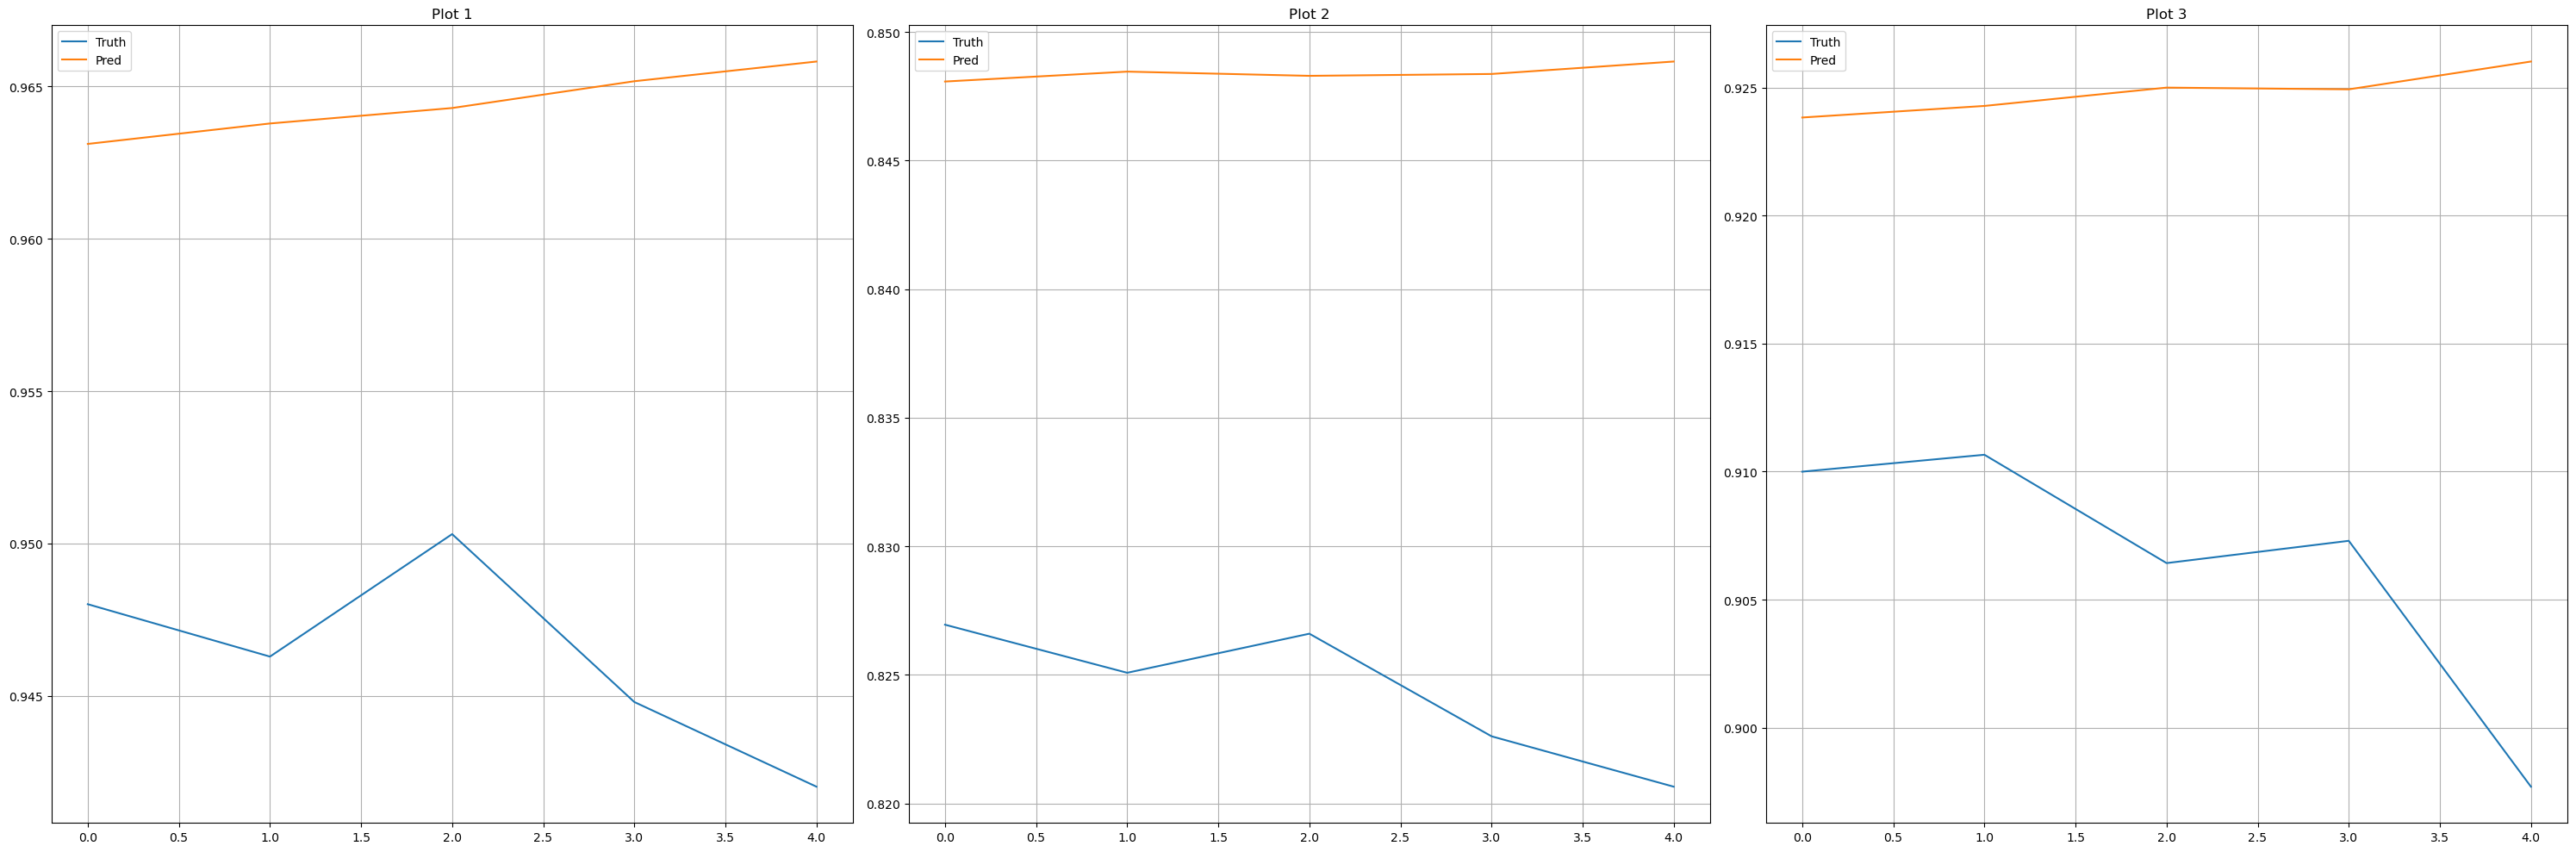

In [27]:
truth_prophet = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]
pred_prophet = [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))]
draw_pred_truth(truth_prophet, pred_prophet)

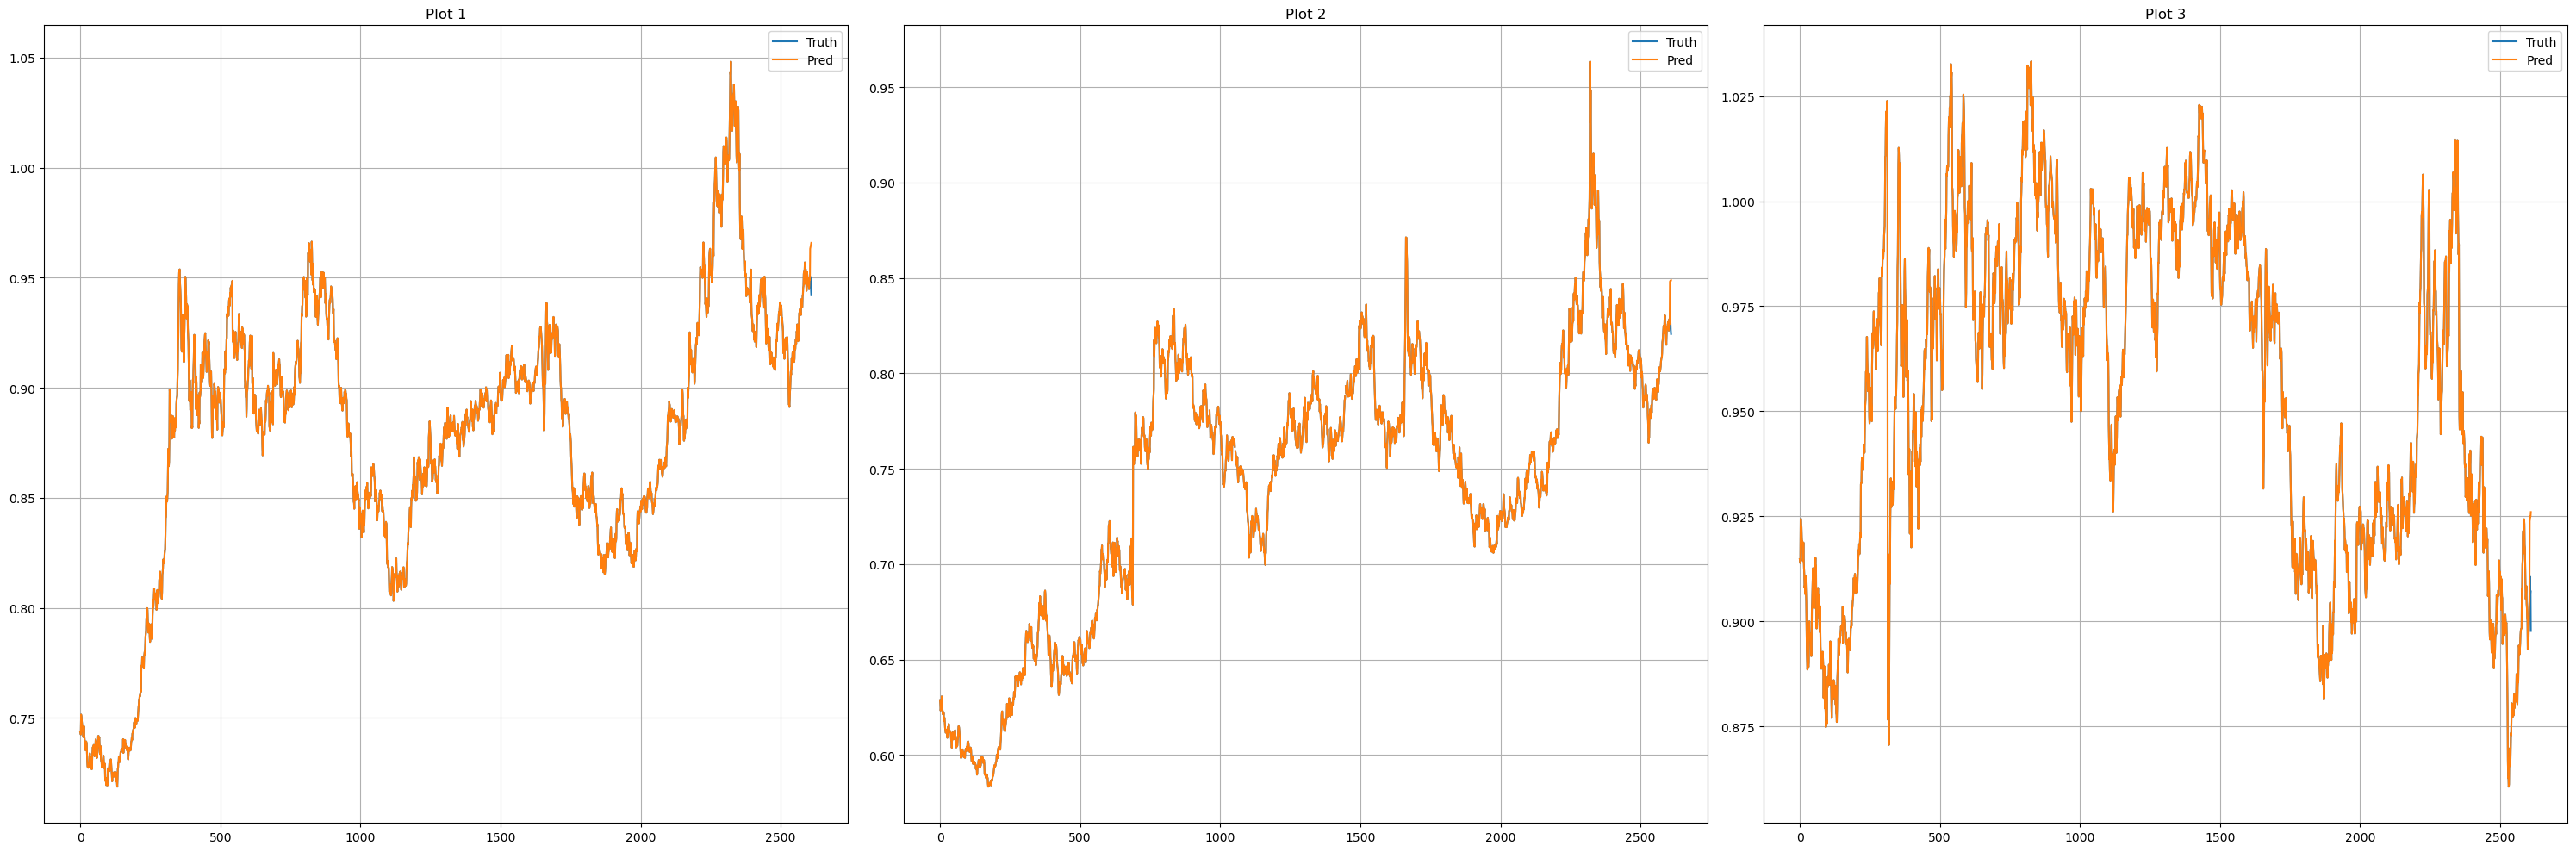

In [28]:
train_pred_prophet = [np.concatenate((df_train_prophet[i]['y'].to_numpy(), prophet_models[i][1]['yhat'].to_numpy()), axis=0) for i in range(len(df_train_prophet))]
# print(len(train_pred_prophet))
draw_pred_truth([df_all_prophet[i]['y'].to_numpy() for i in range(len(df_all_prophet))], train_pred_prophet)

## Hyper parameter tunning to find the best model

In [29]:
# Define a range of hyperparameter values to search
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1], # default 0.05
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10], # default 10
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10], # default 10
}
best_mse = float('inf')
best_params = {}
ground_truth = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]

# Iterate through the parameter grid and find the best hyperparameters
for params in ParameterGrid(param_grid):
    print(f"params is {params}")
    para_models = []
    for curve_data in df_train_prophet:
        # Create a Prophet model with the current hyperparameters
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale']
        )
        
        # Fit the model on the training data
        model.fit(curve_data)
        
        last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
        # Create a date range for the next 5 trading days, excluding weekends
        future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
        # Create a DataFrame with these dates
        future_df = pd.DataFrame({'ds': future_dates})
        # Make predictions
        forecast = model.predict(future_df)

        para_models.append((model, forecast))
    _, mse = calculate_mse(ground_truth, [para_models[i][1]['yhat'].to_numpy() for i in range(len(para_models))])
    print(f"MSE is {mse}")
    # Check if the current set of hyperparameters results in a better model
    if mse < best_mse:
        best_mse = mse
        best_params = params

print("Best Hyperparameters:")
print(best_params)
print("Best MSE:", best_mse)

20:48:54 - cmdstanpy - INFO - Chain [1] start processing


params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


20:48:55 - cmdstanpy - INFO - Chain [1] done processing
20:48:55 - cmdstanpy - INFO - Chain [1] start processing
20:48:55 - cmdstanpy - INFO - Chain [1] done processing
20:48:55 - cmdstanpy - INFO - Chain [1] start processing
20:48:55 - cmdstanpy - INFO - Chain [1] done processing
20:48:55 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018836529198180615
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


20:48:56 - cmdstanpy - INFO - Chain [1] done processing
20:48:56 - cmdstanpy - INFO - Chain [1] start processing
20:48:56 - cmdstanpy - INFO - Chain [1] done processing
20:48:56 - cmdstanpy - INFO - Chain [1] start processing
20:48:57 - cmdstanpy - INFO - Chain [1] done processing
20:48:57 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018820339220951998
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


20:48:57 - cmdstanpy - INFO - Chain [1] done processing
20:48:57 - cmdstanpy - INFO - Chain [1] start processing
20:48:57 - cmdstanpy - INFO - Chain [1] done processing
20:48:58 - cmdstanpy - INFO - Chain [1] start processing
20:48:58 - cmdstanpy - INFO - Chain [1] done processing
20:48:58 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0187562842807555
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


20:48:58 - cmdstanpy - INFO - Chain [1] done processing
20:48:58 - cmdstanpy - INFO - Chain [1] start processing
20:48:59 - cmdstanpy - INFO - Chain [1] done processing
20:48:59 - cmdstanpy - INFO - Chain [1] start processing
20:48:59 - cmdstanpy - INFO - Chain [1] done processing
20:48:59 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018794031107938324
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


20:48:59 - cmdstanpy - INFO - Chain [1] done processing
20:49:00 - cmdstanpy - INFO - Chain [1] start processing
20:49:00 - cmdstanpy - INFO - Chain [1] done processing
20:49:00 - cmdstanpy - INFO - Chain [1] start processing
20:49:00 - cmdstanpy - INFO - Chain [1] done processing
20:49:00 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018836529198180615
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


20:49:01 - cmdstanpy - INFO - Chain [1] done processing
20:49:01 - cmdstanpy - INFO - Chain [1] start processing
20:49:01 - cmdstanpy - INFO - Chain [1] done processing
20:49:01 - cmdstanpy - INFO - Chain [1] start processing
20:49:01 - cmdstanpy - INFO - Chain [1] done processing
20:49:02 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018820339220951998
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


20:49:02 - cmdstanpy - INFO - Chain [1] done processing
20:49:02 - cmdstanpy - INFO - Chain [1] start processing
20:49:02 - cmdstanpy - INFO - Chain [1] done processing
20:49:02 - cmdstanpy - INFO - Chain [1] start processing
20:49:03 - cmdstanpy - INFO - Chain [1] done processing
20:49:03 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0187562842807555
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


20:49:03 - cmdstanpy - INFO - Chain [1] done processing
20:49:03 - cmdstanpy - INFO - Chain [1] start processing
20:49:03 - cmdstanpy - INFO - Chain [1] done processing
20:49:04 - cmdstanpy - INFO - Chain [1] start processing
20:49:04 - cmdstanpy - INFO - Chain [1] done processing
20:49:04 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018794031107938324
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


20:49:04 - cmdstanpy - INFO - Chain [1] done processing
20:49:04 - cmdstanpy - INFO - Chain [1] start processing
20:49:05 - cmdstanpy - INFO - Chain [1] done processing
20:49:05 - cmdstanpy - INFO - Chain [1] start processing
20:49:05 - cmdstanpy - INFO - Chain [1] done processing
20:49:05 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018836529198180615
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


20:49:05 - cmdstanpy - INFO - Chain [1] done processing
20:49:06 - cmdstanpy - INFO - Chain [1] start processing
20:49:06 - cmdstanpy - INFO - Chain [1] done processing
20:49:06 - cmdstanpy - INFO - Chain [1] start processing
20:49:06 - cmdstanpy - INFO - Chain [1] done processing
20:49:06 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018820339220951998
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


20:49:07 - cmdstanpy - INFO - Chain [1] done processing
20:49:07 - cmdstanpy - INFO - Chain [1] start processing
20:49:07 - cmdstanpy - INFO - Chain [1] done processing
20:49:07 - cmdstanpy - INFO - Chain [1] start processing
20:49:07 - cmdstanpy - INFO - Chain [1] done processing
20:49:08 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0187562842807555
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


20:49:08 - cmdstanpy - INFO - Chain [1] done processing
20:49:08 - cmdstanpy - INFO - Chain [1] start processing
20:49:08 - cmdstanpy - INFO - Chain [1] done processing
20:49:08 - cmdstanpy - INFO - Chain [1] start processing
20:49:09 - cmdstanpy - INFO - Chain [1] done processing
20:49:09 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018794031107938324
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


20:49:09 - cmdstanpy - INFO - Chain [1] done processing
20:49:09 - cmdstanpy - INFO - Chain [1] start processing
20:49:09 - cmdstanpy - INFO - Chain [1] done processing
20:49:10 - cmdstanpy - INFO - Chain [1] start processing
20:49:10 - cmdstanpy - INFO - Chain [1] done processing
20:49:10 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018836529198180615
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


20:49:10 - cmdstanpy - INFO - Chain [1] done processing
20:49:10 - cmdstanpy - INFO - Chain [1] start processing
20:49:11 - cmdstanpy - INFO - Chain [1] done processing
20:49:11 - cmdstanpy - INFO - Chain [1] start processing
20:49:11 - cmdstanpy - INFO - Chain [1] done processing
20:49:11 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018820339220951998
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


20:49:12 - cmdstanpy - INFO - Chain [1] done processing
20:49:12 - cmdstanpy - INFO - Chain [1] start processing
20:49:12 - cmdstanpy - INFO - Chain [1] done processing
20:49:12 - cmdstanpy - INFO - Chain [1] start processing
20:49:12 - cmdstanpy - INFO - Chain [1] done processing
20:49:12 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0187562842807555
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


20:49:13 - cmdstanpy - INFO - Chain [1] done processing
20:49:13 - cmdstanpy - INFO - Chain [1] start processing
20:49:13 - cmdstanpy - INFO - Chain [1] done processing
20:49:13 - cmdstanpy - INFO - Chain [1] start processing
20:49:13 - cmdstanpy - INFO - Chain [1] done processing
20:49:14 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018794031107938324
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


20:49:14 - cmdstanpy - INFO - Chain [1] done processing
20:49:14 - cmdstanpy - INFO - Chain [1] start processing
20:49:15 - cmdstanpy - INFO - Chain [1] done processing
20:49:15 - cmdstanpy - INFO - Chain [1] start processing
20:49:15 - cmdstanpy - INFO - Chain [1] done processing
20:49:16 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015998175347751532
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


20:49:16 - cmdstanpy - INFO - Chain [1] done processing
20:49:16 - cmdstanpy - INFO - Chain [1] start processing
20:49:17 - cmdstanpy - INFO - Chain [1] done processing
20:49:17 - cmdstanpy - INFO - Chain [1] start processing
20:49:17 - cmdstanpy - INFO - Chain [1] done processing
20:49:17 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015926536286644984
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


20:49:18 - cmdstanpy - INFO - Chain [1] done processing
20:49:18 - cmdstanpy - INFO - Chain [1] start processing
20:49:19 - cmdstanpy - INFO - Chain [1] done processing
20:49:19 - cmdstanpy - INFO - Chain [1] start processing
20:49:20 - cmdstanpy - INFO - Chain [1] done processing
20:49:20 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015935961994793395
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


20:49:20 - cmdstanpy - INFO - Chain [1] done processing
20:49:21 - cmdstanpy - INFO - Chain [1] start processing
20:49:21 - cmdstanpy - INFO - Chain [1] done processing
20:49:21 - cmdstanpy - INFO - Chain [1] start processing
20:49:21 - cmdstanpy - INFO - Chain [1] done processing
20:49:22 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01595448801020736
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


20:49:22 - cmdstanpy - INFO - Chain [1] done processing
20:49:22 - cmdstanpy - INFO - Chain [1] start processing
20:49:23 - cmdstanpy - INFO - Chain [1] done processing
20:49:23 - cmdstanpy - INFO - Chain [1] start processing
20:49:23 - cmdstanpy - INFO - Chain [1] done processing
20:49:24 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015998175347751532
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


20:49:24 - cmdstanpy - INFO - Chain [1] done processing
20:49:24 - cmdstanpy - INFO - Chain [1] start processing
20:49:25 - cmdstanpy - INFO - Chain [1] done processing
20:49:25 - cmdstanpy - INFO - Chain [1] start processing
20:49:25 - cmdstanpy - INFO - Chain [1] done processing
20:49:25 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015926536286644984
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


20:49:26 - cmdstanpy - INFO - Chain [1] done processing
20:49:26 - cmdstanpy - INFO - Chain [1] start processing
20:49:27 - cmdstanpy - INFO - Chain [1] done processing
20:49:27 - cmdstanpy - INFO - Chain [1] start processing
20:49:28 - cmdstanpy - INFO - Chain [1] done processing
20:49:28 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015935961994793395
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


20:49:28 - cmdstanpy - INFO - Chain [1] done processing
20:49:28 - cmdstanpy - INFO - Chain [1] start processing
20:49:29 - cmdstanpy - INFO - Chain [1] done processing
20:49:29 - cmdstanpy - INFO - Chain [1] start processing
20:49:29 - cmdstanpy - INFO - Chain [1] done processing
20:49:29 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01595448801020736
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


20:49:30 - cmdstanpy - INFO - Chain [1] done processing
20:49:30 - cmdstanpy - INFO - Chain [1] start processing
20:49:31 - cmdstanpy - INFO - Chain [1] done processing
20:49:31 - cmdstanpy - INFO - Chain [1] start processing
20:49:31 - cmdstanpy - INFO - Chain [1] done processing
20:49:31 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015998175347751532
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


20:49:32 - cmdstanpy - INFO - Chain [1] done processing
20:49:32 - cmdstanpy - INFO - Chain [1] start processing
20:49:32 - cmdstanpy - INFO - Chain [1] done processing
20:49:33 - cmdstanpy - INFO - Chain [1] start processing
20:49:33 - cmdstanpy - INFO - Chain [1] done processing
20:49:33 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015926536286644984
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


20:49:34 - cmdstanpy - INFO - Chain [1] done processing
20:49:34 - cmdstanpy - INFO - Chain [1] start processing
20:49:35 - cmdstanpy - INFO - Chain [1] done processing
20:49:35 - cmdstanpy - INFO - Chain [1] start processing
20:49:35 - cmdstanpy - INFO - Chain [1] done processing
20:49:36 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015935961994793395
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


20:49:36 - cmdstanpy - INFO - Chain [1] done processing
20:49:36 - cmdstanpy - INFO - Chain [1] start processing
20:49:37 - cmdstanpy - INFO - Chain [1] done processing
20:49:37 - cmdstanpy - INFO - Chain [1] start processing
20:49:37 - cmdstanpy - INFO - Chain [1] done processing
20:49:37 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01595448801020736
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


20:49:38 - cmdstanpy - INFO - Chain [1] done processing
20:49:38 - cmdstanpy - INFO - Chain [1] start processing
20:49:39 - cmdstanpy - INFO - Chain [1] done processing
20:49:39 - cmdstanpy - INFO - Chain [1] start processing
20:49:39 - cmdstanpy - INFO - Chain [1] done processing
20:49:39 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015998175347751532
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


20:49:40 - cmdstanpy - INFO - Chain [1] done processing
20:49:40 - cmdstanpy - INFO - Chain [1] start processing
20:49:40 - cmdstanpy - INFO - Chain [1] done processing
20:49:41 - cmdstanpy - INFO - Chain [1] start processing
20:49:41 - cmdstanpy - INFO - Chain [1] done processing
20:49:41 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015926536286644984
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


20:49:42 - cmdstanpy - INFO - Chain [1] done processing
20:49:42 - cmdstanpy - INFO - Chain [1] start processing
20:49:43 - cmdstanpy - INFO - Chain [1] done processing
20:49:43 - cmdstanpy - INFO - Chain [1] start processing
20:49:43 - cmdstanpy - INFO - Chain [1] done processing
20:49:44 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015935961994793395
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


20:49:44 - cmdstanpy - INFO - Chain [1] done processing
20:49:44 - cmdstanpy - INFO - Chain [1] start processing
20:49:45 - cmdstanpy - INFO - Chain [1] done processing
20:49:45 - cmdstanpy - INFO - Chain [1] start processing
20:49:45 - cmdstanpy - INFO - Chain [1] done processing
20:49:45 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01595448801020736
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


20:49:46 - cmdstanpy - INFO - Chain [1] done processing
20:49:46 - cmdstanpy - INFO - Chain [1] start processing
20:49:47 - cmdstanpy - INFO - Chain [1] done processing
20:49:47 - cmdstanpy - INFO - Chain [1] start processing
20:49:47 - cmdstanpy - INFO - Chain [1] done processing
20:49:48 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015314405839860004
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


20:49:48 - cmdstanpy - INFO - Chain [1] done processing
20:49:49 - cmdstanpy - INFO - Chain [1] start processing
20:49:49 - cmdstanpy - INFO - Chain [1] done processing
20:49:49 - cmdstanpy - INFO - Chain [1] start processing
20:49:50 - cmdstanpy - INFO - Chain [1] done processing
20:49:50 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015295367119741509
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


20:49:51 - cmdstanpy - INFO - Chain [1] done processing
20:49:52 - cmdstanpy - INFO - Chain [1] start processing
20:49:52 - cmdstanpy - INFO - Chain [1] done processing
20:49:52 - cmdstanpy - INFO - Chain [1] start processing
20:49:53 - cmdstanpy - INFO - Chain [1] done processing
20:49:53 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0153086028135619
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


20:49:54 - cmdstanpy - INFO - Chain [1] done processing
20:49:54 - cmdstanpy - INFO - Chain [1] start processing
20:49:55 - cmdstanpy - INFO - Chain [1] done processing
20:49:55 - cmdstanpy - INFO - Chain [1] start processing
20:49:55 - cmdstanpy - INFO - Chain [1] done processing
20:49:56 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015336799486973127
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


20:49:56 - cmdstanpy - INFO - Chain [1] done processing
20:49:57 - cmdstanpy - INFO - Chain [1] start processing
20:49:57 - cmdstanpy - INFO - Chain [1] done processing
20:49:57 - cmdstanpy - INFO - Chain [1] start processing
20:49:58 - cmdstanpy - INFO - Chain [1] done processing
20:49:58 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015314405839860004
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


20:49:59 - cmdstanpy - INFO - Chain [1] done processing
20:49:59 - cmdstanpy - INFO - Chain [1] start processing
20:49:59 - cmdstanpy - INFO - Chain [1] done processing
20:50:00 - cmdstanpy - INFO - Chain [1] start processing
20:50:01 - cmdstanpy - INFO - Chain [1] done processing
20:50:01 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015295367119741509
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


20:50:02 - cmdstanpy - INFO - Chain [1] done processing
20:50:02 - cmdstanpy - INFO - Chain [1] start processing
20:50:03 - cmdstanpy - INFO - Chain [1] done processing
20:50:03 - cmdstanpy - INFO - Chain [1] start processing
20:50:03 - cmdstanpy - INFO - Chain [1] done processing
20:50:03 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0153086028135619
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


20:50:04 - cmdstanpy - INFO - Chain [1] done processing
20:50:04 - cmdstanpy - INFO - Chain [1] start processing
20:50:05 - cmdstanpy - INFO - Chain [1] done processing
20:50:05 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
20:50:06 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015336799486973127
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


20:50:07 - cmdstanpy - INFO - Chain [1] done processing
20:50:07 - cmdstanpy - INFO - Chain [1] start processing
20:50:07 - cmdstanpy - INFO - Chain [1] done processing
20:50:07 - cmdstanpy - INFO - Chain [1] start processing
20:50:08 - cmdstanpy - INFO - Chain [1] done processing
20:50:08 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015314405839860004
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


20:50:09 - cmdstanpy - INFO - Chain [1] done processing
20:50:09 - cmdstanpy - INFO - Chain [1] start processing
20:50:10 - cmdstanpy - INFO - Chain [1] done processing
20:50:10 - cmdstanpy - INFO - Chain [1] start processing
20:50:11 - cmdstanpy - INFO - Chain [1] done processing
20:50:11 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015295367119741509
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


20:50:12 - cmdstanpy - INFO - Chain [1] done processing
20:50:12 - cmdstanpy - INFO - Chain [1] start processing
20:50:13 - cmdstanpy - INFO - Chain [1] done processing
20:50:13 - cmdstanpy - INFO - Chain [1] start processing
20:50:13 - cmdstanpy - INFO - Chain [1] done processing
20:50:14 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0153086028135619
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


20:50:14 - cmdstanpy - INFO - Chain [1] done processing
20:50:15 - cmdstanpy - INFO - Chain [1] start processing
20:50:15 - cmdstanpy - INFO - Chain [1] done processing
20:50:15 - cmdstanpy - INFO - Chain [1] start processing
20:50:16 - cmdstanpy - INFO - Chain [1] done processing
20:50:16 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015336799486973127
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


20:50:17 - cmdstanpy - INFO - Chain [1] done processing
20:50:17 - cmdstanpy - INFO - Chain [1] start processing
20:50:17 - cmdstanpy - INFO - Chain [1] done processing
20:50:18 - cmdstanpy - INFO - Chain [1] start processing
20:50:18 - cmdstanpy - INFO - Chain [1] done processing
20:50:18 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015314405839860004
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


20:50:19 - cmdstanpy - INFO - Chain [1] done processing
20:50:19 - cmdstanpy - INFO - Chain [1] start processing
20:50:20 - cmdstanpy - INFO - Chain [1] done processing
20:50:20 - cmdstanpy - INFO - Chain [1] start processing
20:50:21 - cmdstanpy - INFO - Chain [1] done processing
20:50:21 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015295367119741509
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


20:50:22 - cmdstanpy - INFO - Chain [1] done processing
20:50:22 - cmdstanpy - INFO - Chain [1] start processing
20:50:23 - cmdstanpy - INFO - Chain [1] done processing
20:50:23 - cmdstanpy - INFO - Chain [1] start processing
20:50:24 - cmdstanpy - INFO - Chain [1] done processing
20:50:24 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0153086028135619
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


20:50:25 - cmdstanpy - INFO - Chain [1] done processing
20:50:25 - cmdstanpy - INFO - Chain [1] start processing
20:50:25 - cmdstanpy - INFO - Chain [1] done processing
20:50:26 - cmdstanpy - INFO - Chain [1] start processing
20:50:26 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015336799486973127
Best Hyperparameters:
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
Best MSE: 0.015295367119741509


In [30]:
# Best Hyperparameters:
# {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
# Best MSE: 0.07732153857925472

## Now predict using the best model 

20:50:26 - cmdstanpy - INFO - Chain [1] start processing
20:50:27 - cmdstanpy - INFO - Chain [1] done processing
20:50:27 - cmdstanpy - INFO - Chain [1] start processing
20:50:28 - cmdstanpy - INFO - Chain [1] done processing
20:50:28 - cmdstanpy - INFO - Chain [1] start processing
20:50:29 - cmdstanpy - INFO - Chain [1] done processing


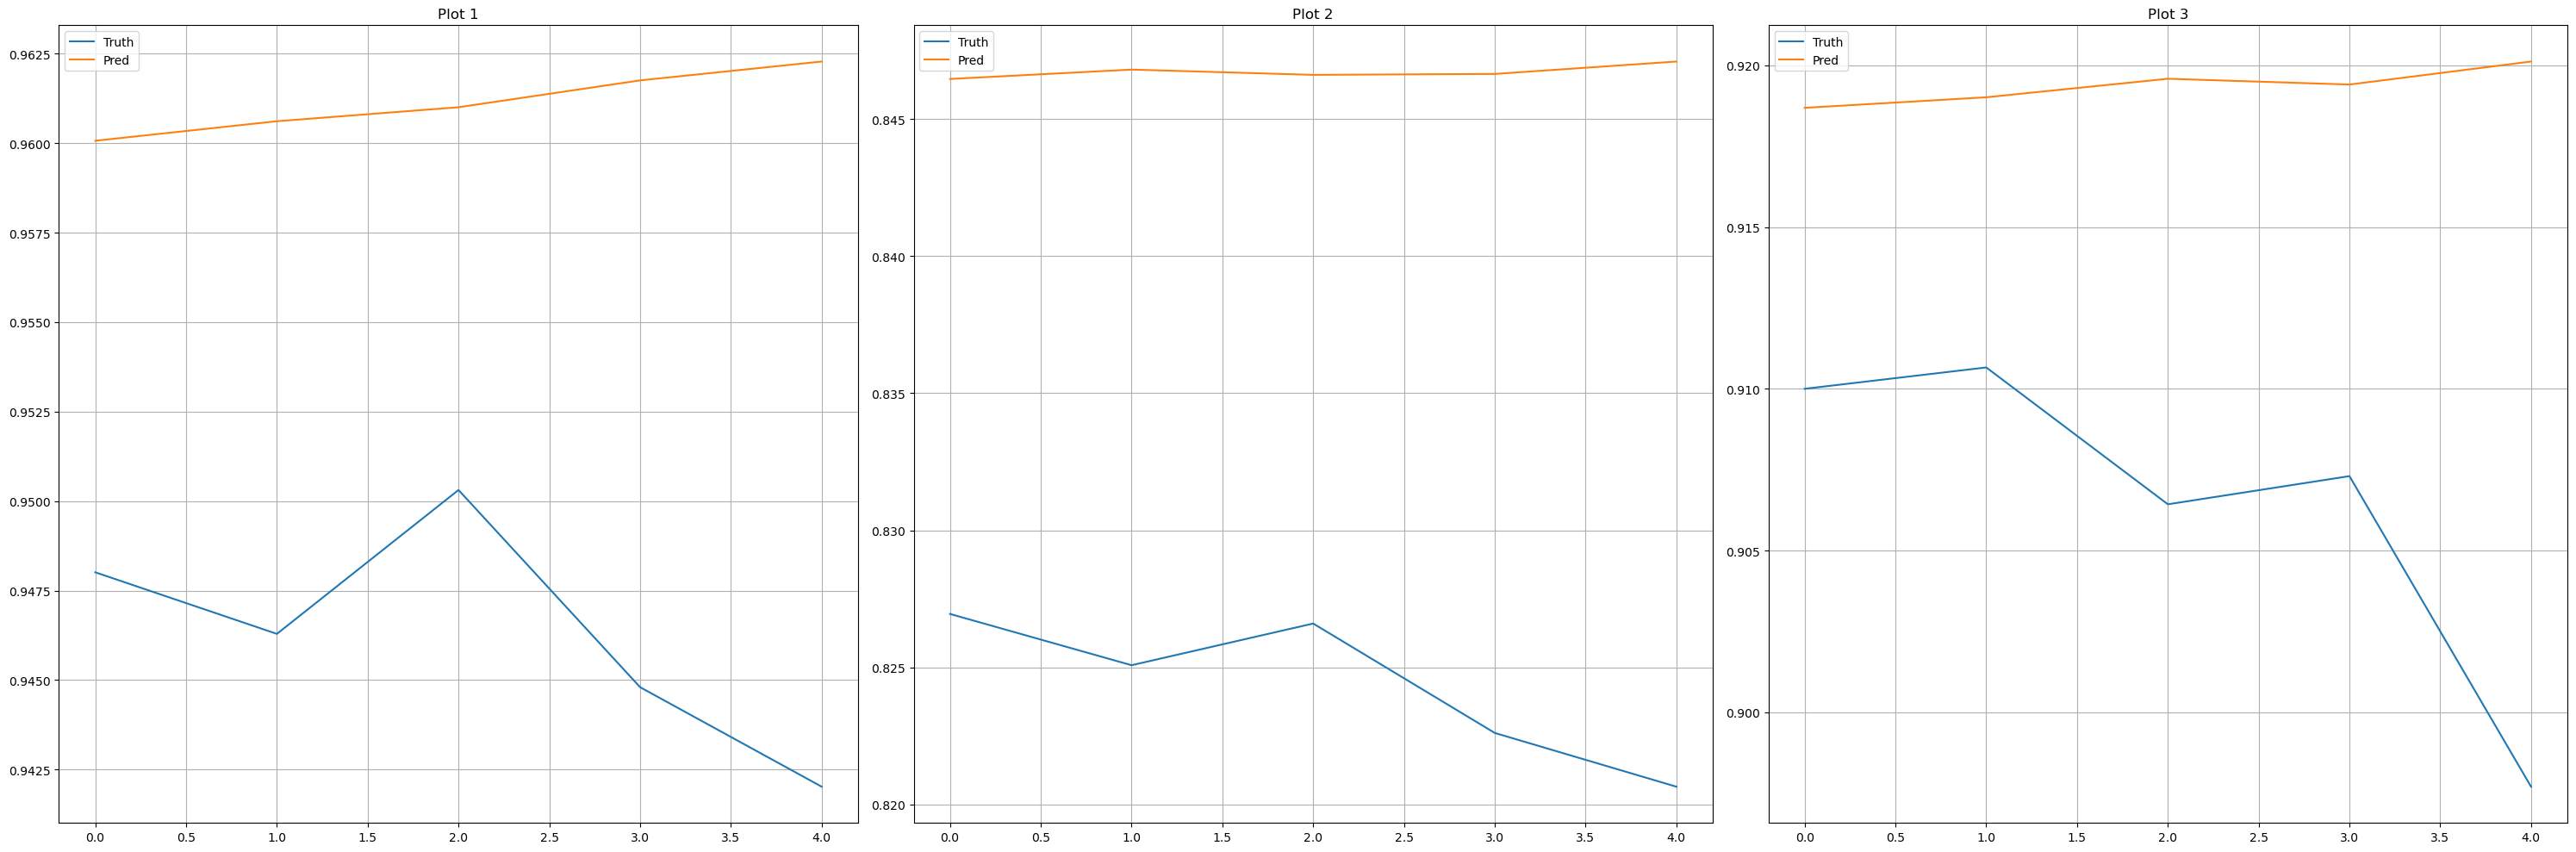

In [31]:
prophet_models = []

for curve_data in df_train_prophet:
    model = Prophet(
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=0.01,
        holidays_prior_scale=0.1
    )
    model.fit(curve_data)

    last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
    # Create a date range for the next 5 trading days, excluding weekends
    future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
    # Create a DataFrame with these dates
    future_df = pd.DataFrame({'ds': future_dates})
    # Make predictions
    forecast = model.predict(future_df)
    # Store the model and its forecast in a list
    prophet_models.append((model, forecast))

truth_prophet = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]
pred_prophet = [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))]
draw_pred_truth(truth_prophet, pred_prophet)

# ARIMA

In [32]:
#split train_dataset into train_dataset and validation_dataset, we set validation_dataset size to be 5, which conforms to test_dataset size
train_size=len(df_train[0][:-5])

train=np.array(df_train[0]['rate'])[:train_size]
val=np.array(df_train[0]['rate'])[train_size:]

In [33]:
print(train.shape,val.shape)

(2597,) (5,)


In [34]:
# train ARIMA model
from statsmodels.tsa.arima.model import ARIMA

#Since we have already applied difference on data, we set d=0 here.
p,d,q=1,2,1
model = ARIMA(train, order=(p, d, q))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2597
Model:                 ARIMA(1, 2, 1)   Log Likelihood               10179.533
Date:                Sun, 10 Dec 2023   AIC                         -20353.066
Time:                        20:50:29   BIC                         -20335.482
Sample:                             0   HQIC                        -20346.695
                               - 2597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0033      0.020      0.169      0.866      -0.035       0.042
ma.L1         -0.7564      0.016    -46.935      0.000      -0.788      -0.725
sigma2      2.288e-05   4.43e-07     51.680      0.0

In [35]:
train

array([0.74107, 0.73981, 0.74222, ..., 0.9458 , 0.9489 , 0.9446 ])

In [36]:
# prediction
train_predictions = result.predict(start=1, end=train.shape[0])
print(train_predictions)

val_predictions = result.get_forecast(len(val)).predicted_mean
print(val_predictions)

[1.111605   0.73855    0.74287081 ... 0.94543074 0.94939189 0.94389979]
[0.94389979 0.94321149 0.94252323 0.94183498 0.94114672]


In [37]:
val

array([0.94429, 0.93722, 0.94381, 0.94632, 0.94657])

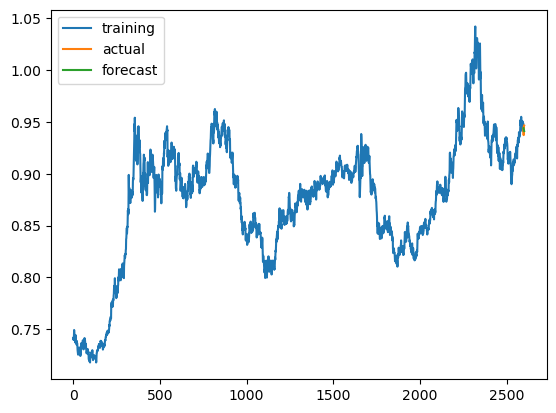

In [38]:
plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

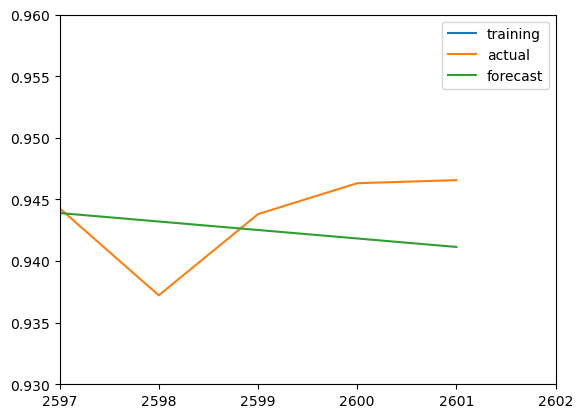

In [39]:
plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.xlim(len(train), len(train)+len(val))
plt.ylim(0.93, 0.96)
plt.legend()

In [40]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(train_predictions,train)
val_mse = mean_squared_error(val_predictions, val)

print("train_MSE:", train_mse)
print("val_MSE:", val_mse)

train_MSE: 5.5470984925806673e-05
val_MSE: 1.744668888697345e-05


## Fine-tuning

In [41]:
#gird search
min_val_mse=1e9
optimal_p=1
optimal_d=1
optimal_q=1
for p in range(1,6):
    for d in range(1,3):
        for q in range(1,6):
            model = ARIMA(train, order=(p, d, q))
            result = model.fit()
            train_predictions = result.predict(start=1, end=train.shape[0])
            val_predictions = result.get_forecast(len(val)).predicted_mean
            train_mse = mean_squared_error(train_predictions,train)
            val_mse = mean_squared_error(val_predictions, val)
            if (val_mse<min_val_mse):
                min_val_mse=val_mse
                optimal_p=p
                optimal_q=q
                optimal_d=d
            print(f"p={p},d={d},q={q}:")
            print("train_MSE:", train_mse)
            print("val_MSE:", val_mse)
            print("-------------------------------------------------------------")

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=1,d=1,q=1:
train_MSE: 5.622281423440493e-08
val_MSE: 1.2565155350801575e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=1,d=1,q=2:
train_MSE: 4.804952919739813e-09
val_MSE: 1.2490400324902994e-05
-------------------------------------------------------------
p=1,d=1,q=3:
train_MSE: 6.49042496815994e-09
val_MSE: 1.2451416386084449e-05
-------------------------------------------------------------
p=1,d=1,q=4:
train_MSE: 6.97465565448031e-09
val_MSE: 1.2455803487631764e-05
-------------------------------------------------------------
p=1,d=1,q=5:
train_MSE: 9.812872026938083e-09
val_MSE: 1.2386002807662587e-05
-------------------------------------------------------------
p=1,d=2,q=1:
train_MSE: 5.5470984925806673e-05
val_MSE: 1.744668888697345e-05
-------------------------------------------------------------
p=1,d=2,q=2:
train_MSE: 5.444922588870262e-05
val_MSE: 1.3811083240070375e-05
-------------------------------------------------------------
p=1,d=2,q=3:
train_MSE: 5.392101297152516e-05
val_MSE: 1.2391002579279686e-05
-------------------------------------------------------------
p=1,d=2,q=4:
train_MSE

C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=2,d=1,q=1:
train_MSE: 2.4936379066018063e-19
val_MSE: 1.240478034555449e-05
-------------------------------------------------------------
p=2,d=1,q=2:
train_MSE: 1.030850606977851e-08
val_MSE: 1.2831243207051391e-05
-------------------------------------------------------------
p=2,d=1,q=3:
train_MSE: 6.3345216959982945e-09
val_MSE: 1.240198055080693e-05
-------------------------------------------------------------
p=2,d=1,q=4:
train_MSE: 7.690821419789563e-09
val_MSE: 1.2471527911695103e-05
-------------------------------------------------------------
p=2,d=1,q=5:
train_MSE: 1.0382692315734839e-08
val_MSE: 1.2328061681661546e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=2,d=2,q=1:
train_MSE: 5.291284802883075e-05
val_MSE: 1.2671061608247005e-05
-------------------------------------------------------------
p=2,d=2,q=2:
train_MSE: 5.451466717594866e-05
val_MSE: 1.4160193079725876e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=2,d=2,q=3:
train_MSE: 5.293794529679054e-05
val_MSE: 1.255183539559168e-05
-------------------------------------------------------------
p=2,d=2,q=4:
train_MSE: 5.366374076623117e-05
val_MSE: 1.248391813251164e-05
-------------------------------------------------------------
p=2,d=2,q=5:
train_MSE: 5.354521322864649e-05
val_MSE: 1.2520504470951571e-05
-------------------------------------------------------------
p=3,d=1,q=1:
train_MSE: 6.879139688956545e-09
val_MSE: 1.2442444839213524e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3,d=1,q=2:
train_MSE: 6.027666837319974e-08
val_MSE: 1.2441906748052018e-05
-------------------------------------------------------------
p=3,d=1,q=3:
train_MSE: 6.324322566387968e-09
val_MSE: 1.240151541411499e-05
-------------------------------------------------------------
p=3,d=1,q=4:
train_MSE: 7.288370535212674e-09
val_MSE: 1.2348049865133908e-05
-------------------------------------------------------------
p=3,d=1,q=5:
train_MSE: 1.0922985424356063e-08
val_MSE: 1.2238072530606662e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3,d=2,q=1:
train_MSE: 5.297830289151083e-05
val_MSE: 1.2827338693980974e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3,d=2,q=2:
train_MSE: 5.334580552134118e-05
val_MSE: 1.4002028583094691e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3,d=2,q=3:
train_MSE: 5.29903829240478e-05
val_MSE: 1.2402232903929508e-05
-------------------------------------------------------------
p=3,d=2,q=4:
train_MSE: 5.3671923691527754e-05
val_MSE: 1.260512783757542e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=3,d=2,q=5:
train_MSE: 5.321332312241417e-05
val_MSE: 1.0646306992936824e-05
-------------------------------------------------------------
p=4,d=1,q=1:
train_MSE: 6.7979547611947096e-09
val_MSE: 1.2444017705576073e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=4,d=1,q=2:
train_MSE: 6.211087648471199e-18
val_MSE: 1.2404782511732778e-05
-------------------------------------------------------------
p=4,d=1,q=3:
train_MSE: 6.262433714541803e-09
val_MSE: 1.2425736624494726e-05
-------------------------------------------------------------
p=4,d=1,q=4:
train_MSE: 7.170292371834989e-08
val_MSE: 1.1099927286430458e-05
-------------------------------------------------------------
p=4,d=1,q=5:
train_MSE: 1.2671070920735286e-08
val_MSE: 1.2047952987937658e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=1:
train_MSE: 5.3109960875683784e-05
val_MSE: 1.3612967664358174e-05
-------------------------------------------------------------
p=4,d=2,q=2:
train_MSE: 5.470253091078859e-05
val_MSE: 1.2786413655255078e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=3:
train_MSE: 5.308539020431339e-05
val_MSE: 1.2943551068228992e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=4:
train_MSE: 5.313007667080002e-05
val_MSE: 1.315169441612612e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=5:
train_MSE: 5.3023665031417526e-05
val_MSE: 1.1202489844342511e-05
-------------------------------------------------------------
p=5,d=1,q=1:
train_MSE: 1.0487296333199021e-08
val_MSE: 1.2417456991388741e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=5,d=1,q=2:
train_MSE: 7.415985009419689e-18
val_MSE: 1.2404782063336612e-05
-------------------------------------------------------------
p=5,d=1,q=3:
train_MSE: 9.642275358287118e-09
val_MSE: 1.236197140303682e-05
-------------------------------------------------------------
p=5,d=1,q=4:
train_MSE: 2.5442501652254116e-08
val_MSE: 1.167017857451341e-05
-------------------------------------------------------------
p=5,d=1,q=5:
train_MSE: 1.3717269623758068e-08
val_MSE: 1.1962171464760032e-05
-------------------------------------------------------------
p=5,d=2,q=1:
train_MSE: 5.5640869777641494e-05
val_MSE: 1.599997510424177e-05
-------------------------------------------------------------
p=5,d=2,q=2:
train_MSE: 5.432707085511049e-05
val_MSE: 1.27044606733236e-05
-------------------------------------------------------------
p=5,d=2,q=3:
train_MSE: 5.387940663379804e-05
val_MSE: 1.168292697543803e-05
-------------------------------------------------------------
p=5,d=2,q=4:
train_MSE:

In [42]:
print(optimal_p,optimal_d,optimal_q)

5 2 5


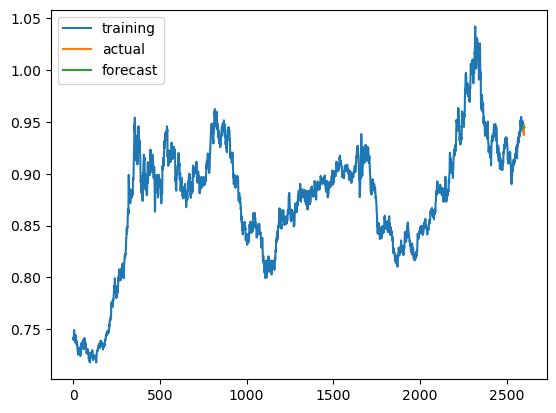

In [43]:
#visualize the best case
model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
result = model.fit()

train_predictions = result.predict(start=1, end=train.shape[0])
val_predictions = result.get_forecast(len(val)).predicted_mean

plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

## Modularization

In [44]:
def fine_tune(df):
    #split dataset
    train_size=len(df[:-5])

    train=np.array(df['rate'])[:train_size]
    val=np.array(df['rate'])[train_size:]
    
    #fine-tuning
    min_val_mse=1e9
    optimal_p=1
    optimal_d=1
    optimal_q=1
    for p in range(1,6):
        for d in range(1,3):
            for q in range(1,6):
                model = ARIMA(train, order=(p, d, q))
                result = model.fit()
                train_predictions = result.predict(start=1, end=train.shape[0])
                val_predictions = result.get_forecast(len(val)).predicted_mean
                train_mse = mean_squared_error(train_predictions,train)
                val_mse = mean_squared_error(val_predictions, val)
                if (val_mse<min_val_mse):
                    min_val_mse=val_mse
                    optimal_p=p
                    optimal_q=q
                    optimal_d=d
    
    return optimal_p,optimal_d,optimal_q

In [45]:
#find best hyper parameters for each dataset
best_parameters=[]
for i in range(len(filepath)):
    best_parameters.append(fine_tune(df_train[i]))

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization

C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: 

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting au

In [46]:
print(best_parameters)

[(5, 2, 5), (2, 1, 5), (5, 1, 5)]


In [47]:
def get_best_model(df,best_parameter):
    #train using the whole training dataset
    train=np.array(df['rate'])

    
    #visualize the best case
    optimal_p, optimal_d, optimal_q=best_parameter
    model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
    result = model.fit()

    train_predictions = result.predict(start=1, end=train.shape[0])

    plt.plot(train,label='training')
    plt.plot(train_predictions,label='train_prediction')
    plt.show()

    return result

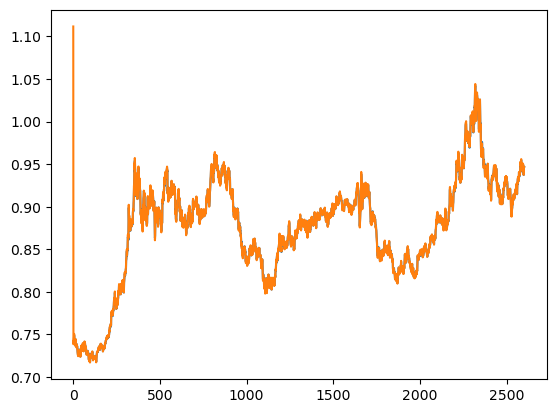

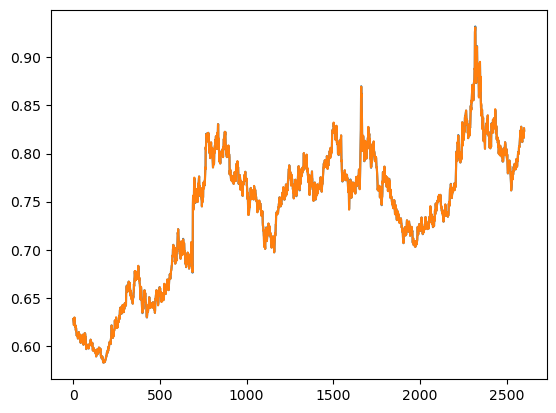

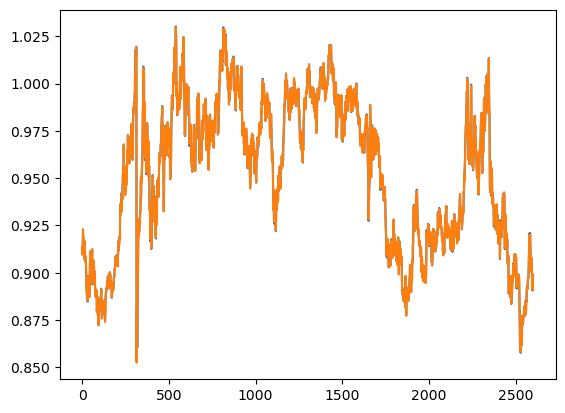

In [48]:
models=[]
for i in range(len(filepath)):
    models.append(get_best_model(df_train[i],best_parameters[i]))

In [74]:
ARIMA_predictions=[]
for i in range(len(filepath)):
    ARIMA_predictions.append(models[i].get_forecast(len(df_test[i])).predicted_mean)
ARIMA_predictions=np.array(ARIMA_predictions)
ARIMA_predictions

array([[0.94680873, 0.94720008, 0.94831501, 0.94823409, 0.9480505 ],
       [0.82381117, 0.82383511, 0.82380072, 0.82354914, 0.82338919],
       [0.89894091, 0.89923411, 0.89942069, 0.8995849 , 0.89951564]])

# Multivariate SARIMA

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [50]:
df_test

[         rate
 2605  0.94675
 2606  0.94206
 2607  0.94526
 2608  0.94455
 2609  0.94170,
          rate
 2605  0.82551
 2606  0.82198
 2607  0.82290
 2608  0.82087
 2609  0.82022,
          rate
 2605  0.90240
 2606  0.90206
 2607  0.90980
 2608  0.90555
 2609  0.90610]

In [51]:
df_combined = [pd.concat([train_df, test_df]) for train_df, test_df in zip(df_train, df_test)]
df_combined[0]

,rate
0,0.74107
1,0.73981
2,0.74222
3,0.73975
4,0.74576
...,...
2605,0.94675
2606,0.94206
2607,0.94526
2608,0.94455


In [52]:
usd_eur_rate = np.array(df_combined[0]["rate"])
usd_gbp_rate = np.array(df_combined[1]["rate"])
usd_chf_rate = np.array(df_combined[2]["rate"])
selected_dates = pd.to_datetime(df_temp['date'])
selected_dates_val = pd.to_datetime(df_temp['date'][:-5])
usd_eur_series = pd.Series(usd_eur_rate, index=selected_dates)
usd_gbp_series = pd.Series(usd_gbp_rate, index=selected_dates)
usd_chf_series = pd.Series(usd_chf_rate, index=selected_dates)
exog_data_val = pd.DataFrame({'Oil_Price': oil_price[:-5], 'Gold_Price': gold_price[:-5], 'Stock_Prices': stock_price[:-5]}, index=selected_dates_val)

## Hyper parameter tunning 

In [53]:
def fine_tune(df):
    #split dataset
    train_size=df.shape[0] - 5

    train=df[:train_size]
    val=df[train_size:]

    trainSeries = pd.Series(train, index=selected_dates_val)
    
    #fine-tuning
    min_val_mse=1e9
    optimal_p=1
    optimal_d=1
    optimal_q=1
    for p in [5,7,11]:
        for d in range(1,3):
            for q in [0,3,7]:
                model = SARIMAX(trainSeries, exog=exog_data_val, order=(p,d,q))
                model_fit = model.fit()
                forecast = model_fit.get_forecast(steps=5, exog=exog_data_val.iloc[-5:])
                val_predictions = forecast.predicted_mean
                val_mse = mean_squared_error(val_predictions, val)
                if (val_mse<min_val_mse):
                    min_val_mse=val_mse
                    optimal_p=p
                    optimal_q=q
                    optimal_d=d
    
    return optimal_p,optimal_d,optimal_q

In [54]:
# best_parameters_sarima=[]
# for i in [usd_eur_rate, usd_gbp_rate, usd_chf_rate]:
#     best_parameters_sarima.append(fine_tune(i))

In [55]:
usd_eur_rate = np.array(df_combined[0]["rate"])
usd_gbp_rate = np.array(df_combined[1]["rate"])
usd_chf_rate = np.array(df_combined[2]["rate"])
selected_dates = pd.to_datetime(df_temp['date'])
selected_dates_val = pd.to_datetime(df_temp['date'][:-5])
usd_eur_series = pd.Series(usd_eur_rate, index=selected_dates)
usd_gbp_series = pd.Series(usd_gbp_rate, index=selected_dates)
usd_chf_series = pd.Series(usd_chf_rate, index=selected_dates)
exog_data = pd.DataFrame({'Oil_Price': oil_price, 'Gold_Price': gold_price, 'Stock_Prices': stock_price}, index=selected_dates)

In [56]:
model = SARIMAX(usd_eur_series, exog=exog_data, order=(10,2,7))  # Adjust order (p,d,q) based on your data analysis
model_fit = model.fit()

# Forecasting
forecast = model_fit.get_forecast(steps=5, exog=exog_data.iloc[-5:])  # Last 5 days of exog data for forecasting
predicted_usd_eur_rate = forecast.predicted_mean
predicted_usd_eur_rate

C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_m

2607    0.941323
2608    0.940302
2609    0.939586
2610    0.938249
2611    0.936611
Name: predicted_mean, dtype: float64

In [57]:
model = SARIMAX(usd_gbp_series, exog=exog_data, order=(10,2,0))  # Adjust order (p,d,q) based on your data analysis
model_fit = model.fit()

# Forecasting
forecast = model_fit.get_forecast(steps=5, exog=exog_data.iloc[-5:])  # Last 5 days of exog data for forecasting
predicted_usd_gbp_rate = forecast.predicted_mean
predicted_usd_gbp_rate

C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


2607    0.819850
2608    0.819979
2609    0.820018
2610    0.820369
2611    0.820003
Name: predicted_mean, dtype: float64

In [58]:
model = SARIMAX(usd_chf_series, exog=exog_data, order=(5,1,0))  # Adjust order (p,d,q) based on your data analysis
model_fit = model.fit()

# Forecasting
forecast = model_fit.get_forecast(steps=5, exog=exog_data.iloc[-5:])  # Last 5 days of exog data for forecasting
predicted_usd_chf_rate = forecast.predicted_mean
predicted_usd_chf_rate

C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarn

2607    0.905925
2608    0.907042
2609    0.906577
2610    0.906852
2611    0.906186
Name: predicted_mean, dtype: float64

In [59]:
multi_variate_sarima_pred=[]
multi_variate_sarima_pred.append(np.array(predicted_usd_eur_rate))
multi_variate_sarima_pred.append(np.array(predicted_usd_gbp_rate))
multi_variate_sarima_pred.append(np.array(predicted_usd_chf_rate))
multi_variate_sarima_pred=np.array(multi_variate_sarima_pred)

In [60]:
multi_variate_sarima_pred

array([[0.94132251, 0.94030192, 0.93958579, 0.9382487 , 0.93661131],
       [0.81985007, 0.81997869, 0.82001782, 0.82036863, 0.82000305],
       [0.90592465, 0.90704185, 0.90657717, 0.90685161, 0.90618626]])

# SARIMA

In [61]:
#seperates data set
!pip3 install pmdarima 
from pmdarima import auto_arima
train_size=len(df_train[0][:-5])

train=np.array(df_train[0]['rate'])[:train_size]
val=np.array(df_train[0]['rate'])[train_size:]

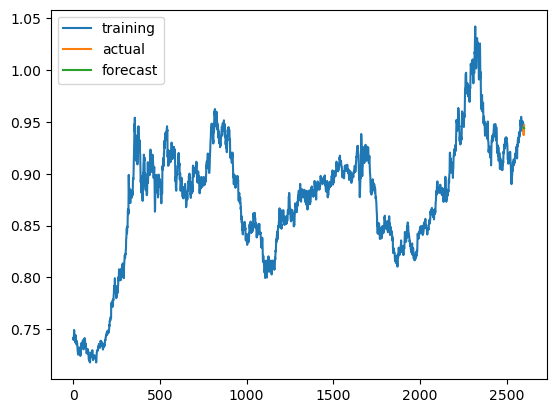

In [62]:
# train SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# initial parameters
sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1,1,1,12))
result = sarima.fit()
train_prediction = result.predict()
val_predictions = result.get_forecast(len(val)).predicted_mean

plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

## Error Calculation

In [63]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(result.predict(),train)
val_mse = mean_squared_error(val_predictions, val)

## Fine tuning

In [64]:
def get_best_model_sarima(df,best_parameter):
    #train using the whole training dataset
    train=np.array(df['rate'])

    
    #visualize the best case
    optimal_p, optimal_d, optimal_q, optimal_P, optimal_D, optimal_Q, M=best_parameter
    model =  SARIMAX(train, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(optimal_P,optimal_D,optimal_Q,M))
    result = model.fit()

    train_predictions = result.predict(start=1, end=train.shape[0])

    plt.plot(train,label='training')
    plt.plot(train_predictions,label='train_prediction')
    plt.show()

    return result

In [65]:
def fine_tune_sarima(df):
    #split dataset
    train_size=len(df[:-5])

    train=np.array(df['rate'])[:train_size]
    val=np.array(df['rate'])[train_size:]
    
    auto_para = auto_arima(train, start_p=1, start_q=1,
                          max_p=4, max_q=4, m=12,
                          start_P=0, seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',
                          stepwise=True)
    
    non_s = auto_para.order
    seasonal_part = auto_para.seasonal_order
    
    return non_s[0],non_s[1],non_s[2], seasonal_part[0], seasonal_part[1], seasonal_part[2],seasonal_part[3]
    
    
    #fine-tuning
    
    
    
#     min_val_mse=1e9
#     p_optimized=1
#     d_optimized=1
#     q_optimized=1
#     for p in range(0,2):
#         for d in range(0,2):
#             for q in range(0,2):
#                 for P in range(0,2):
#                     for D in range(0,2):
#                         for Q in range(0,2):
#                             for M in range()
#                             model = SARIMAX(train, order=(p, d, q), seasonal_order=(P,D,Q,12))
#                             result = model.fit()
#                             train_predictions = result.predict(start=1, end=train.shape[0])
#                             val_predictions = result.get_forecast(len(val)).predicted_mean
#                             train_mse = mean_squared_error(train_predictions,train)
#                             val_mse = mean_squared_error(val_predictions, val)
#                             if (val_mse<min_val_mse):
#                                 min_val_mse=val_mse
#                                 p_optimized=p
#                                 q_optimized=q
#                                 d_optimized=d
#                             print(f"p={p},d={d},q={q}:")
#                             print("train_MSE:", train_mse)
#                             print("val_MSE:", val_mse)
#                             print("-------------------------------------------------------------")

#     smallest_error = -1
#     for q in range(1, 3):
#         for d in range(1, 3):
#             for p in range(1, 3):
#                 sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(p,d,q,12))
#                 sarima_model.fit()
#                 train_prediction = result.predict()
#                 val_predictions = result.get_forecast(len(val)).predicted_mean
#                 if (smallest_error == -1):
#                     smallest_error = mean_squared_error(val_predictions, val)
#                 else:
#                     err = mean_squared_error(val_predictions, val)
#                     if (err < smallest_error):
#                         smallest_error = err
#                         q_optimized = q
#                         d_optimized = d
#                         p_optimized = p
    

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-20267.157, Time=1.72 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-18843.953, Time=0.77 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-19594.526, Time=1.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-20269.561, Time=2.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-18842.484, Time=0.24 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=6.63 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-20381.407, Time=3.40 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=10.69 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=6.50 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-20378.994, Time=2.66 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=-20378.947, Time=2.44 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=8.43 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=inf, Time=12.75 sec
 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=-20379.357, Time=5.88 sec

Best model:  ARIMA(0,1,

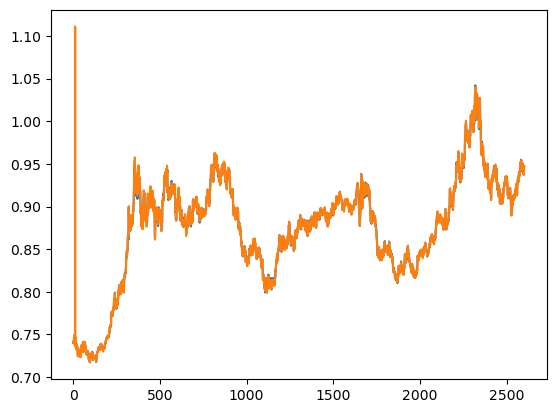

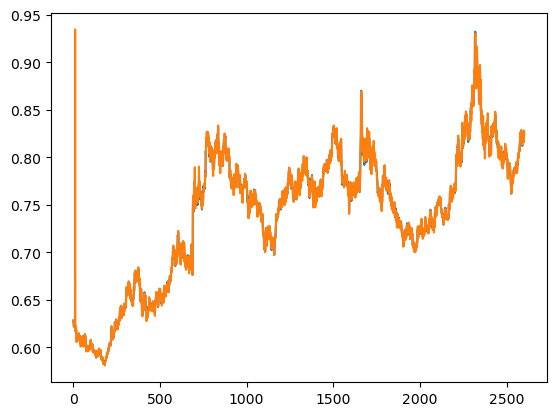

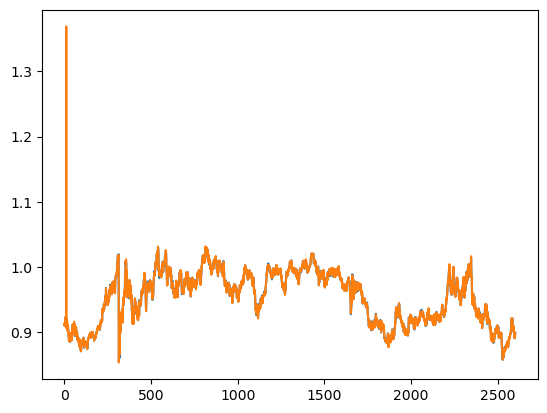

In [66]:
#find best hyper parameters for each dataset
best_parameters_sarima=[]
for i in range(3):
    best_parameters_sarima.append(fine_tune_sarima(df_train[i]))

models_sarima=[]
for i in range(3):
    models_sarima.append(get_best_model_sarima(df_train[i],best_parameters_sarima[i]))


In [67]:
SARIMA_predictions=[]
for i in range(3):
    SARIMA_predictions.append(models_sarima[i].get_forecast(len(df_test[i])).predicted_mean)

In [68]:
print(SARIMA_predictions)

[array([0.94706916, 0.94907724, 0.9505545 , 0.94971486, 0.94872215]), array([0.82426161, 0.82830381, 0.82880018, 0.82638128, 0.82741682]), array([0.8992274 , 0.90064122, 0.90136962, 0.90068838, 0.89964297])]


# Model Ensembling

In [69]:
pred_prophet=np.array(pred_prophet)
pred_prophet

array([[0.96006805, 0.96061385, 0.96100468, 0.96175484, 0.96228176],
       [0.84645936, 0.84680116, 0.84660925, 0.84664327, 0.84709535],
       [0.91868523, 0.91901172, 0.91958416, 0.91940545, 0.92011661]])

In [75]:
ARIMA_predictions

array([[0.94680873, 0.94720008, 0.94831501, 0.94823409, 0.9480505 ],
       [0.82381117, 0.82383511, 0.82380072, 0.82354914, 0.82338919],
       [0.89894091, 0.89923411, 0.89942069, 0.8995849 , 0.89951564]])

In [71]:
SARIMA_predictions=np.array(SARIMA_predictions)
SARIMA_predictions

array([[0.94706916, 0.94907724, 0.9505545 , 0.94971486, 0.94872215],
       [0.82426161, 0.82830381, 0.82880018, 0.82638128, 0.82741682],
       [0.8992274 , 0.90064122, 0.90136962, 0.90068838, 0.89964297]])

In [78]:
true_rate=[]
for i in range(len(filepath)):
    true_rate.append(np.array(df_test[i]).squeeze())
true_rate

[array([0.94675, 0.94206, 0.94526, 0.94455, 0.9417 ]),
 array([0.82551, 0.82198, 0.8229 , 0.82087, 0.82022]),
 array([0.9024 , 0.90206, 0.9098 , 0.90555, 0.9061 ])]

In [79]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

weights = []
bias=[]
for i in range(len(filepath)):
    x1=pred_prophet[i]
    x2=ARIMA_predictions[i]
    x3=SARIMA_predictions[i]

    X_train = np.column_stack((x1, x2, x3))
    y_train = true_rate[i]
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    weights.append(model.coef_)
    bias.append(model.intercept_)

In [80]:
print(weights)
print(bias)

[array([-4.7882923 ,  8.43087521, -2.64325569]), array([-0.18984805,  7.76692165, -0.62447109]), array([ 5.6153508 , -6.22152945,  2.40494522])]
[0.064704767463726, -4.89793273442358, -0.8272905063213027]


## Re-train on the whole train dataset

In [81]:
#prophet re-train
prophet_midterm_models = []

for curve_data in df_all_prophet:
    model = Prophet(
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=0.01,
        holidays_prior_scale=0.1
    )
    model.fit(curve_data)

    last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
    # Create a date range for the next 5 trading days, excluding weekends
    future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
    # print(future_dates)
    # Create a DataFrame with these dates
    future_df = pd.DataFrame({'ds': future_dates})
    # Make predictions
    forecast = model.predict(future_df)
    # Store the model and its forecast in a list
    prophet_midterm_models.append((model, forecast))

21:02:56 - cmdstanpy - INFO - Chain [1] start processing
21:02:57 - cmdstanpy - INFO - Chain [1] done processing
21:02:57 - cmdstanpy - INFO - Chain [1] start processing
21:02:57 - cmdstanpy - INFO - Chain [1] done processing
21:02:58 - cmdstanpy - INFO - Chain [1] start processing
21:02:58 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
pred_prophet_final = [prophet_midterm_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_midterm_models))]

In [83]:
pred_prophet_final=np.array(pred_prophet_final)
pred_prophet_final

array([[0.9609852 , 0.96155656, 0.9619361 , 0.96260668, 0.96301525],
       [0.84504868, 0.84539674, 0.84517614, 0.84514294, 0.84550422],
       [0.9187741 , 0.91957928, 0.91996934, 0.92055842, 0.92037557]])

In [84]:
#ARIMA re-train
pred_ARIMA_final=[]
for i in range(len(filepath)):
    train=np.array(df_raw[i]['rate'])
    optimal_p, optimal_d, optimal_q=best_parameters[i]
    model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
    result = model.fit()
    test_predicionts = result.get_forecast(5).predicted_mean
    pred_ARIMA_final.append(test_predicionts)

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [85]:
pred_ARIMA_final=np.array(pred_ARIMA_final)
pred_ARIMA_final

array([[0.94214322, 0.94222556, 0.94231201, 0.94213203, 0.94229482],
       [0.82014079, 0.82035321, 0.82056947, 0.82071869, 0.82075098],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151]])

In [86]:
#SARIMA re-train
pred_SARIMA_final=[]
for i in range(len(filepath)):
    train=np.array(df_raw[i]['rate'])
    optimal_p, optimal_d, optimal_q=best_parameters[i]
    sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1,1,1,12))
    result = model.fit()
    test_predicionts = result.get_forecast(5).predicted_mean
    pred_SARIMA_final.append(test_predicionts)

In [87]:
pred_SARIMA_final=np.array(pred_SARIMA_final)
pred_SARIMA_final

array([[0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151]])

## Combine results

In [88]:
weights

[array([-4.7882923 ,  8.43087521, -2.64325569]),
 array([-0.18984805,  7.76692165, -0.62447109]),
 array([ 5.6153508 , -6.22152945,  2.40494522])]

In [89]:
pred_prophet_final

array([[0.9609852 , 0.96155656, 0.9619361 , 0.96260668, 0.96301525],
       [0.84504868, 0.84539674, 0.84517614, 0.84514294, 0.84550422],
       [0.9187741 , 0.91957928, 0.91996934, 0.92055842, 0.92037557]])

In [90]:
pred_ARIMA_final

array([[0.94214322, 0.94222556, 0.94231201, 0.94213203, 0.94229482],
       [0.82014079, 0.82035321, 0.82056947, 0.82071869, 0.82075098],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151]])

In [91]:
pred_SARIMA_final

array([[0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151]])

In [92]:
final_pred_combine=[]
for i in range(3):
    final_pred_combine.append(pred_prophet_final[i]*weights[i][0]+pred_ARIMA_final[i]*weights[i][1]+pred_SARIMA_final[i]*weights[i][2]+bias[i])
final_pred_combine

[array([1.01126476, 1.00854984, 1.00883324, 1.00465042, 1.004325  ]),
 array([0.74577247, 0.74719711, 0.7492428 , 0.75053701, 0.75078022]),
 array([0.87374158, 0.87729071, 0.88146203, 0.88555755, 0.88490395])]

We have not yet found a good way to do model ensembling.  
It's obvious that Linear Regression is a bad approach.

# Compute and compare max profit using 4 different methods

In [93]:
def get_max_profit(rate,exchange_path):
    #We initially have 1000 dollars
    principal=1000
    # 5 days in total, we have 4 chances to make a profit
    for i in range(4):
        #Here, we initialize rate_increase to be 1. This is to prevent elements in rate_increase are all smaller than 1.
        rate_increase=np.array([1])
        #Here, we only need the first three predictions.
        for j in range(3):
            rate_increase=np.append(rate_increase,rate[j][i+1]/rate[j][i])
        max_rate_increase=np.max(rate_increase)
        exchange_path.append(np.argmax(rate_increase))
        principal*=max_rate_increase
    return principal-1000,exchange_path

In [94]:
pred_prophet_final=np.concatenate((pred_prophet_final,(pred_prophet_final[1]/pred_prophet_final[0]).reshape(1,5)))
pred_prophet_final=np.concatenate((pred_prophet_final,(pred_prophet_final[2]/pred_prophet_final[1]).reshape(1,5)))
pred_prophet_final

array([[0.9609852 , 0.96155656, 0.9619361 , 0.96260668, 0.96301525],
       [0.84504868, 0.84539674, 0.84517614, 0.84514294, 0.84550422],
       [0.9187741 , 0.91957928, 0.91996934, 0.92055842, 0.92037557],
       [0.8793566 , 0.87919606, 0.87861984, 0.87797328, 0.87797595],
       [1.087244  , 1.08774878, 1.08849422, 1.08923399, 1.08855231]])

In [95]:
pred_ARIMA_final=np.concatenate((pred_ARIMA_final,(pred_ARIMA_final[1]/pred_ARIMA_final[0]).reshape(1,5)))
pred_ARIMA_final=np.concatenate((pred_ARIMA_final,(pred_ARIMA_final[2]/pred_ARIMA_final[1]).reshape(1,5)))
pred_ARIMA_final

array([[0.94214322, 0.94222556, 0.94231201, 0.94213203, 0.94229482],
       [0.82014079, 0.82035321, 0.82056947, 0.82071869, 0.82075098],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151],
       [0.87050544, 0.8706548 , 0.87080443, 0.87112917, 0.87101294],
       [1.10481025, 1.1048347 , 1.10391099, 1.10345881, 1.10329629]])

In [96]:
pred_SARIMA_final=np.concatenate((pred_SARIMA_final,(pred_SARIMA_final[1]/pred_SARIMA_final[0]).reshape(1,5)))
pred_SARIMA_final=np.concatenate((pred_SARIMA_final,(pred_SARIMA_final[2]/pred_SARIMA_final[1]).reshape(1,5)))
pred_SARIMA_final

array([[0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151],
       [0.90609996, 0.90635469, 0.90583565, 0.90562927, 0.90553151],
       [1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

In [97]:
multi_variate_sarima_pred=np.concatenate((multi_variate_sarima_pred,(multi_variate_sarima_pred[1]/multi_variate_sarima_pred[0]).reshape(1,5)))
multi_variate_sarima_pred=np.concatenate((multi_variate_sarima_pred,(multi_variate_sarima_pred[2]/multi_variate_sarima_pred[1]).reshape(1,5)))
multi_variate_sarima_pred

array([[0.94132251, 0.94030192, 0.93958579, 0.9382487 , 0.93661131],
       [0.81985007, 0.81997869, 0.82001782, 0.82036863, 0.82000305],
       [0.90592465, 0.90704185, 0.90657717, 0.90685161, 0.90618626],
       [0.87095555, 0.87203766, 0.87274396, 0.8743616 , 0.87549985],
       [1.1049882 , 1.10617735, 1.10555789, 1.10541966, 1.10510107]])

In [98]:
#0:USD-->USD 1:USD-->GBP 2:USD-->GBP 3:USD-->CHF
exchange_path_prophet=[]
predict_profit_prophet,exchange_path_prophet=get_max_profit(pred_prophet_final,exchange_path_prophet)
print(predict_profit_prophet)
print(exchange_path_prophet)

2.4272692792428643
[3, 3, 1, 2]


In [99]:
exchange_path_ARIMA=[]
predict_profit_ARIMA,exchange_path_ARIMA=get_max_profit(pred_ARIMA_final,exchange_path_ARIMA)
print(predict_profit_ARIMA)
print(exchange_path_ARIMA)

0.8996934984260179
[3, 2, 2, 1]


In [100]:
exchange_path_SARIMA=[]
predict_profit_SARIMA,exchange_path_SARIMA=get_max_profit(pred_SARIMA_final,exchange_path_SARIMA)
print(predict_profit_SARIMA)
print(exchange_path_SARIMA)

0.28112831235876
[1, 0, 0, 0]


In [101]:
exchange_path_multi_variate_sarima=[]
predict_profit_multi_variate_sarima,exchange_path_multi_variate_sarima=get_max_profit(multi_variate_sarima_pred,exchange_path_multi_variate_sarima)
print(predict_profit_multi_variate_sarima)
print(exchange_path_multi_variate_sarima)

1.7093604711656099
[3, 2, 2, 0]


# Compared to ground-truth data

In [102]:
filepath_true=['USDEUR=X_true.csv','USDGBP=X_true.csv','USDCHF=X_true.csv']

In [103]:
true_market=[]
for path in filepath_true:
    df_temp_=pd.read_csv(path)
    #We no longer need date, because we can use index.
    df_temp_=df_temp_[['Close']]
    df_temp_.columns=['rate']
    true_market.append(np.array(df_temp_))
true_market=np.array(true_market).squeeze()

In [104]:
true_market

array([[0.93178, 0.9327 , 0.93492, 0.93367, 0.93742],
       [0.80816, 0.81001, 0.81355, 0.814  , 0.81853],
       [0.89921, 0.8992 , 0.89997, 0.89908, 0.90315]])

In [105]:
exchange_path_true=[]
ground_truth_profit,ground_truth_path=get_max_profit(true_market,exchange_path_true)
print(ground_truth_profit)
print(ground_truth_path)

12.831617501484743
[2, 2, 2, 2]


In [106]:
def mse(y_true, y_pred):
    return (y_true - y_pred) ** 2

In [107]:
print("mse of profit between groud truth and prophet",mse(ground_truth_profit,predict_profit_prophet))

mse of profit between groud truth and prophet 108.25046192966775


In [108]:
print("mse of profit between groud truth and ARIMA",mse(ground_truth_profit,predict_profit_ARIMA))

mse of profit between groud truth and ARIMA 142.37081041476895


In [109]:
print("mse of profit between groud truth and SARIMA",mse(ground_truth_profit,predict_profit_SARIMA))

mse of profit between groud truth and SARIMA 157.5147788863682


In [110]:
print("mse of profit between groud truth and multi-variate SARIMA",mse(ground_truth_profit,predict_profit_multi_variate_sarima))

mse of profit between groud truth and multi-variate SARIMA 123.70460144848339


# Result Visualization

In [111]:
multi_variate_sarima_pred

array([[0.94132251, 0.94030192, 0.93958579, 0.9382487 , 0.93661131],
       [0.81985007, 0.81997869, 0.82001782, 0.82036863, 0.82000305],
       [0.90592465, 0.90704185, 0.90657717, 0.90685161, 0.90618626],
       [0.87095555, 0.87203766, 0.87274396, 0.8743616 , 0.87549985],
       [1.1049882 , 1.10617735, 1.10555789, 1.10541966, 1.10510107]])

In [112]:
pred_prophet_final
pred_ARIMA_final
pred_SARIMA_final
multi_variate_sarima_pred

array([[0.94132251, 0.94030192, 0.93958579, 0.9382487 , 0.93661131],
       [0.81985007, 0.81997869, 0.82001782, 0.82036863, 0.82000305],
       [0.90592465, 0.90704185, 0.90657717, 0.90685161, 0.90618626],
       [0.87095555, 0.87203766, 0.87274396, 0.8743616 , 0.87549985],
       [1.1049882 , 1.10617735, 1.10555789, 1.10541966, 1.10510107]])

In [113]:
predict_profit_prophet
predict_profit_ARIMA
predict_profit_SARIMA
predict_profit_multi_variate_sarima
ground_truth_profit

12.831617501484743

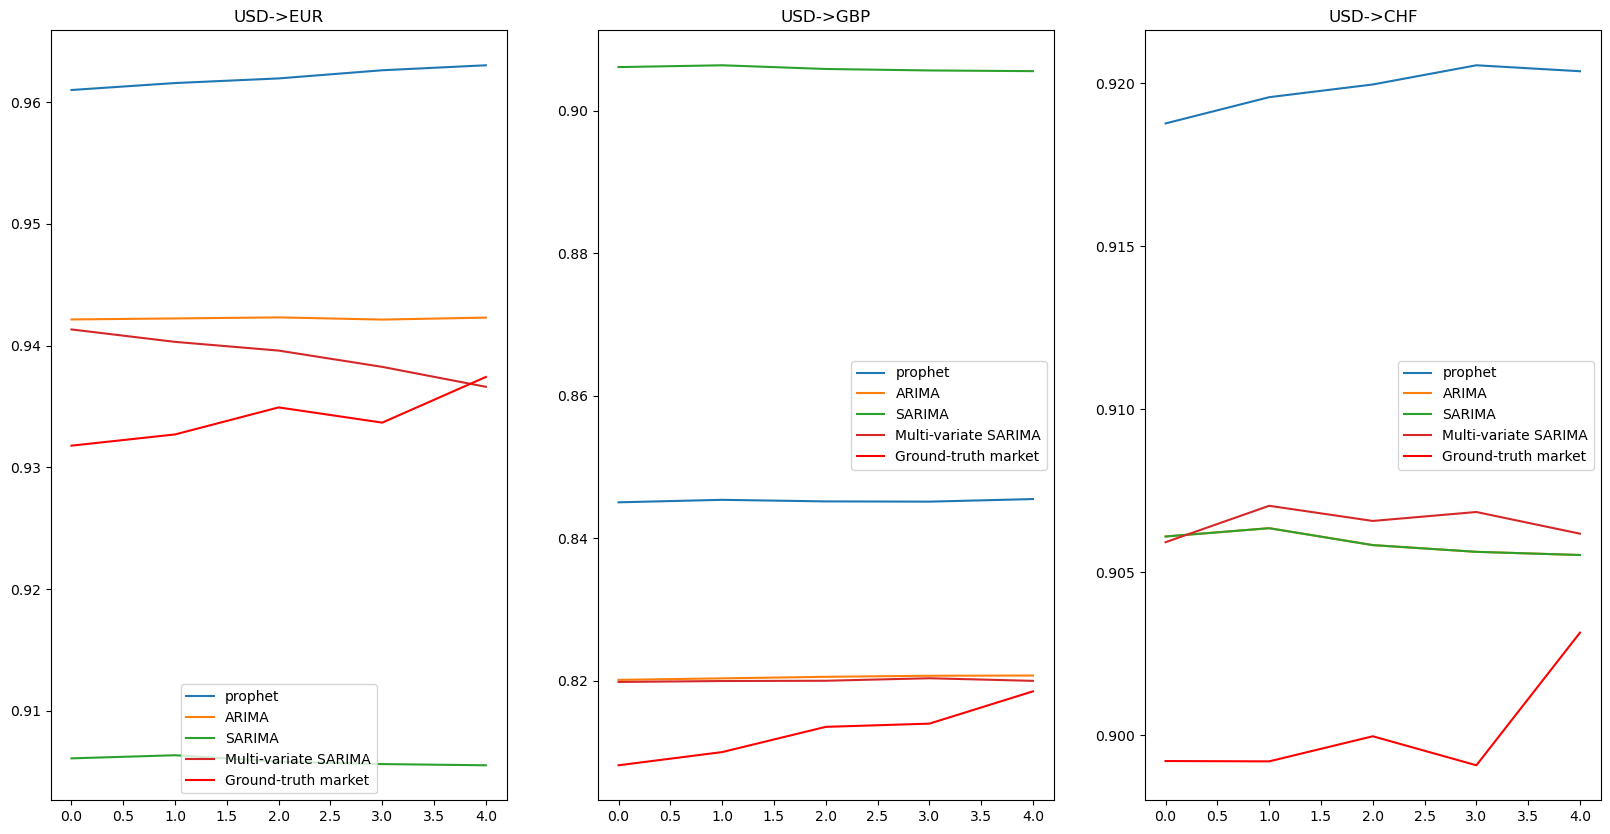

In [114]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 10))

axes[0].plot(pred_prophet_final[0],label='prophet')
axes[0].plot(pred_ARIMA_final[0],label='ARIMA')
axes[0].plot(pred_SARIMA_final[0],label='SARIMA')
axes[0].plot(multi_variate_sarima_pred[0],label='Multi-variate SARIMA')
axes[0].plot(true_market[0],label='Ground-truth market',color='red')
axes[0].set_title('USD->EUR')
axes[0].legend()

axes[1].plot(pred_prophet_final[1],label='prophet')
axes[1].plot(pred_ARIMA_final[1],label='ARIMA')
axes[1].plot(pred_SARIMA_final[1],label='SARIMA')
axes[1].plot(multi_variate_sarima_pred[1],label='Multi-variate SARIMA')
axes[1].plot(true_market[1],label='Ground-truth market',color='red')
axes[1].set_title('USD->GBP')
axes[1].legend()

axes[2].plot(pred_prophet_final[2],label='prophet')
axes[2].plot(pred_ARIMA_final[2],label='ARIMA')
axes[2].plot(pred_SARIMA_final[2],label='SARIMA')
axes[2].plot(multi_variate_sarima_pred[2],label='Multi-variate SARIMA')
axes[2].plot(true_market[2],label='Ground-truth market',color='red')
axes[2].set_title('USD->CHF')
axes[2].legend()

# 显示图形
plt.show()

In [118]:
data = {
    'Prophet': [108.3],
    'ARIMA': [142.4],
    'SARIMA': [157.5],
    'Multi-variate SARIMA': [123.7],
}
df = pd.DataFrame(data)
new_index_mapping = {
    0: 'MSE',
}

df = df.rename(index=new_index_mapping)
df

,Prophet,ARIMA,SARIMA,Multi-variate SARIMA
MSE,108.3,142.4,157.5,123.7


# Final Result and Conclusion

Although prophet produces least MSE, its prediction of future exchange rate is deviated from groud-truth.   
In this case we select multi-variate as our final approach.   
This means we shall exchange USD to CHF on Monday. Then we exchange USD to GBP on Tuesday and Wednesday.  
And the max profit we predict is $1.71.

Discussion and analysis:  
Our result is not as good as epxeted. We assume there are three reasons:
1. Prophet  
The Mean Squared Error (MSE) of the Prophet model is higher than average when compared to other models. This suboptimal performance could be attributed to Prophet's heavy reliance on seasonal trends in the training data. However, current exchange rate data may not exhibit significant seasonality, which could be adversely affecting the model's accuracy.
2. SARIMA  
We assume that SARIMA could be better than ARIMA because of the seasonal nature of financial market. However, SARIMA turns out to be less optimal than ARIMA, even though we used the same grid-search parameter tuning approach. To explain this, we have some assumptions:  
Exchange rate data is irregularly seasonal. If the data does not have a significant regular seasonal pattern, the additional complexity of the SARIMA model might lead to overfitting.  
Exchange rates are influenced by a myriad of complex factors like geopolitical events, economic policies, interest rate changes, and market sentiment. Uni-variate models might perform indeed the same and the difference just comes from noise.  
3. Multi-variate SARIMA  
Multi-variate SARIMA is often regarded as the most effective model among the various options we have considered. Its strength lies in capturing complex seasonal patterns in time series data, making it a preferred choice for forecasting tasks. However, the predictive accuracy of this model might be limited in the context of currency fluctuation forecasting. Currency values are influenced by a multitude of factors, including geopolitical events and wars, which are challenging to quantify and incorporate into any statistical model.   
These external factors, often referred to as exogenous variables, can have a profound and often unpredictable impact on currency markets. Unlike typical market data, events like political unrest or military conflicts do not have a regular pattern and are difficult to encode in a quantitative model like SARIMA. As a result, while SARIMA can capture and predict based on historical patterns in the data, its ability to foresee changes driven by these non-quantifiable factors is limited. This limitation underscores the inherent challenges in modeling and forecasting in the highly dynamic and complex domain of currency exchange rates, where external, non-quantifiable influences play a significant role.